In [1]:
import torch
import numpy as np
import torch as th
import torch.nn as nn
import pandas as pd
from PIL import Image
import imageio.v2 as imageio
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.nn import MaxPool2d
import torch.nn.functional as F
import torch.optim as optim

In [2]:
df =pd.read_csv('HAM10000_metadata.csv')

In [5]:
target = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [6]:
subset_metadata_a = df.sample(frac=0.2, random_state=42) 

In [7]:
num_samples_per_label_a = 300                                                 ## 300 sample for each class
balanced_sub_a = pd.DataFrame()
for label in target:
    label_metadata_a = subset_metadata_a[subset_metadata_a['dx'] == label]
    label_samples_a = label_metadata_a.sample(n=num_samples_per_label_a, random_state=42, replace = True)
    balanced_sub_a = pd.concat([balanced_sub_a, label_samples_a])

In [8]:
size = (64, 64)
images_sub_a = []
for i, row in balanced_sub_a.iterrows():
    img_a = imageio.imread('HAM_data//HAM10000/' + row['image_id'] + '.jpg')
    resized_img = np.array(Image.fromarray(img_a).resize(size))
    images_sub_a.append(resized_img)

In [9]:
images_and_labels_sub_a = []
for i, row in balanced_sub_a.iterrows():
    img_b = imageio.imread('HAM_data/HAM10000/' + row['image_id'] + '.jpg')
    resized_img = np.array(Image.fromarray(img_b).resize(size))
    label = row['dx']
    images_and_labels_sub_a.append((resized_img, label))

In [10]:
images_sub_a, labels_sub_a = zip(*images_and_labels_sub_a)
images_sub_a = np.array(images_sub_a)
labels_sub_a = np.array(labels_sub_a)

# Print the shapes of the resulting arrays
print('Image shape:', images_sub_a.shape)
print('Label shape:', labels_sub_a.shape)

Image shape: (2100, 64, 64, 3)
Label shape: (2100,)


In [11]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_sub_a)

In [12]:
image_tensor = th.FloatTensor(images_sub_a.astype('float32'))
label_tensor = th.FloatTensor(labels_encoded.astype('float32'))

In [13]:
import torchvision.transforms as transforms
from PIL import Image

transform_train = transforms.Compose([
    transforms.RandomCrop(64, padding=0),    
    transforms.RandomHorizontalFlip(),    
    transforms.ToTensor(),    
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply the transformations to the data
x_train_transformed = []
for img in images_sub_a:
    img_pil = Image.fromarray(img)
    img_transformed = transform_train(img_pil)
    x_train_transformed.append(img_transformed)

In [14]:
x_train_transformed = torch.stack(x_train_transformed)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_train_transformed, label_tensor, train_size=0.7, random_state=2019)

In [16]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

In [17]:
batch_size = 30
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [149]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*13*13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)
        
    def forward(self, x):
        x = self.pool1(th.relu(self.conv1(x)))
        x = self.pool2(th.relu(self.conv2(x)))
        x = th.flatten(x, start_dim=1)
        x = th.relu(self.fc1(x))
        x = th.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [50]:
class SparseLinear(nn.Linear):
    def __init__(self, in_features, out_features, sparsity=0.02, **kwargs):
        super(SparseLinear, self).__init__(in_features, out_features, **kwargs)
        self.sparsity = sparsity
        self.mask = nn.Parameter(torch.ones_like(self.weight), requires_grad=False)
        self.num_zeros = int(self.sparsity * self.weight.numel())
        self.reset_mask()

    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)

    def reset_mask(self):
        if self.num_zeros > 0:
            weight = self.weight.view(-1)
            _, indices = torch.topk(torch.abs(weight), k=self.num_zeros)
            mask = torch.ones_like(weight)
            mask[indices] = 0
            self.mask.data.copy_(mask.view(self.weight.size()))

In [51]:
class SparseConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, sparsity=0.02, **kwargs):
        super(SparseConv2d, self).__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.sparsity = sparsity
        self.mask = nn.Parameter(torch.ones_like(self.weight), requires_grad=False)
        self.num_zeros = int(self.sparsity * self.weight.numel())
        self.reset_mask()

    def forward(self, x):
        return F.conv2d(x, self.mask * self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

    def reset_mask(self):
        if self.num_zeros > 0:
            weight = self.weight.view(-1)
            _, indices = torch.topk(torch.abs(weight), k=self.num_zeros)
            mask = torch.ones_like(weight)
            mask[indices] = 0
            self.mask.data.copy_(mask.view(self.weight.size()))

In [52]:
class SparseNet(nn.Module):
    def __init__(self):
        super(SparseNet, self).__init__()
        self.conv1 = SparseConv2d(3, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = SparseConv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = SparseLinear(16*13*13, 120)
        self.fc2 = SparseLinear(120, 84)
        self.fc3 = SparseLinear(84,7)

    def forward(self, x):
        x = self.pool1(th.relu(self.conv1(x)))
        x = self.pool2(th.relu(self.conv2(x)))
        x = th.flatten(x, start_dim=1)
        x = th.relu(self.fc1(x))
        x = th.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def prune(self):
        for module in self.modules():
            if isinstance(module, SparseConv2d) or isinstance(module, SparseLinear):
                weights = module.weight.data.clone()
                num_params = weights.numel()
                k = int(num_params * 0.02)  # prune 50% of weights
                if k > 0:
                    _, indices = torch.topk(torch.abs(weights.view(-1)), k)
                    indices = indices.cpu().numpy()
                    new_weights = weights.view(-1).clone()
                    new_weights[indices] = 0
                    new_weights = new_weights.view(weights.size())
                    module.weight.data = new_weights

In [19]:
model = SparseNet()
lambda_l2 = 0.03
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=lambda_l2)
criterion = nn.CrossEntropyLoss()
train_loss01 = []
test_loss01 = []
num_epochs = 800
_train_loss = 0.0
for epoch in range(num_epochs):
    for i, batch in enumerate(train_dataloader):
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.long())
            # Add L2 regularization to the loss
        l2_reg = sum(torch.norm(param) for param in model.parameters())
        loss += lambda_l2 * l2_reg
        _train_loss +=loss.item()
        loss.backward()
        optimizer.step()
    _train_loss /=len(train_dataloader)
    train_loss01.append(_train_loss)

    _test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets.long())
            _test_loss += loss.item()
    _test_loss /= len(test_dataloader)
    test_loss01.append(_test_loss)
    print(f"Epoch {epoch}: Train_loss = {_train_loss} Test_loss = {_test_loss}")
    model.prune()
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

Epoch 0: Train_loss = 25.001822880336217 Test_loss = 1.746085484822591
Epoch 1: Train_loss = 25.302102525449705 Test_loss = 1.7205452010745095
Epoch 2: Train_loss = 25.261974402013625 Test_loss = 1.755901120957874
Epoch 3: Train_loss = 25.23253682332264 Test_loss = 1.728902328582037
Epoch 4: Train_loss = 25.21583772254579 Test_loss = 1.7320268494742257
Epoch 5: Train_loss = 25.218054289832526 Test_loss = 1.7356773274285453
Epoch 6: Train_loss = 25.22713592091415 Test_loss = 1.7983667055765789
Epoch 7: Train_loss = 25.205989317512678 Test_loss = 1.7318178472064791
Epoch 8: Train_loss = 25.215689901519312 Test_loss = 1.732614210673741
Epoch 9: Train_loss = 25.21252062377493 Test_loss = 1.7911704892203921
Epoch 10: Train_loss = 25.205079059709732 Test_loss = 1.744584009760902
Epoch 11: Train_loss = 25.195156350040712 Test_loss = 1.738060440335955
Epoch 12: Train_loss = 25.216676289011513 Test_loss = 1.799502860932123
Epoch 13: Train_loss = 25.202671431647058 Test_loss = 1.7379996152151198

KeyboardInterrupt: 

In [53]:
# Define the model
model = SparseNet()
num_epochs = 800

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss02 = []
test_loss02 = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    _train_loss = running_loss / len(train_dataloader)
    train_loss02.append(_train_loss)
    
    running_test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets.long())
            running_test_loss += loss.item()
    _test_loss = running_test_loss / len(test_dataloader)
    test_loss02.append(_test_loss)
    
    print('Epoch [%d], train_loss: %.3f, test_loss: %.3f' % (epoch + 1, _train_loss, _test_loss))
    
    # Prune the model after each epoch
    model.prune()

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

Epoch [1], train_loss: 1.793, test_loss: 1.622
Epoch [2], train_loss: 1.593, test_loss: 1.545
Epoch [3], train_loss: 1.452, test_loss: 1.353
Epoch [4], train_loss: 1.370, test_loss: 1.328
Epoch [5], train_loss: 1.282, test_loss: 1.414
Epoch [6], train_loss: 1.237, test_loss: 1.155
Epoch [7], train_loss: 1.187, test_loss: 1.189
Epoch [8], train_loss: 1.141, test_loss: 1.105
Epoch [9], train_loss: 1.088, test_loss: 1.081
Epoch [10], train_loss: 1.040, test_loss: 1.075
Epoch [11], train_loss: 0.989, test_loss: 1.028
Epoch [12], train_loss: 0.959, test_loss: 1.161
Epoch [13], train_loss: 0.962, test_loss: 0.995
Epoch [14], train_loss: 0.926, test_loss: 1.014
Epoch [15], train_loss: 0.848, test_loss: 1.038
Epoch [16], train_loss: 0.855, test_loss: 1.034
Epoch [17], train_loss: 0.822, test_loss: 1.024
Epoch [18], train_loss: 0.767, test_loss: 1.063
Epoch [19], train_loss: 0.765, test_loss: 1.018
Epoch [20], train_loss: 0.727, test_loss: 0.950
Epoch [21], train_loss: 0.757, test_loss: 0.950
E

Epoch [171], train_loss: 0.219, test_loss: 0.826
Epoch [172], train_loss: 0.151, test_loss: 0.814
Epoch [173], train_loss: 0.219, test_loss: 0.703
Epoch [174], train_loss: 0.247, test_loss: 0.715
Epoch [175], train_loss: 0.253, test_loss: 0.775
Epoch [176], train_loss: 0.205, test_loss: 0.893
Epoch [177], train_loss: 0.221, test_loss: 0.815
Epoch [178], train_loss: 0.148, test_loss: 0.736
Epoch [179], train_loss: 0.182, test_loss: 0.761
Epoch [180], train_loss: 0.222, test_loss: 0.813
Epoch [181], train_loss: 0.243, test_loss: 0.881
Epoch [182], train_loss: 0.204, test_loss: 0.823
Epoch [183], train_loss: 0.296, test_loss: 0.836
Epoch [184], train_loss: 0.234, test_loss: 0.736
Epoch [185], train_loss: 0.150, test_loss: 0.793
Epoch [186], train_loss: 0.153, test_loss: 0.843
Epoch [187], train_loss: 0.202, test_loss: 0.947
Epoch [188], train_loss: 0.216, test_loss: 0.857
Epoch [189], train_loss: 0.180, test_loss: 0.738
Epoch [190], train_loss: 0.192, test_loss: 0.845
Epoch [191], train_l

Epoch [339], train_loss: 0.135, test_loss: 0.831
Epoch [340], train_loss: 0.139, test_loss: 0.726
Epoch [341], train_loss: 0.131, test_loss: 0.733
Epoch [342], train_loss: 0.161, test_loss: 0.884
Epoch [343], train_loss: 0.150, test_loss: 0.638
Epoch [344], train_loss: 0.178, test_loss: 0.772
Epoch [345], train_loss: 0.141, test_loss: 0.663
Epoch [346], train_loss: 0.131, test_loss: 0.813
Epoch [347], train_loss: 0.140, test_loss: 0.815
Epoch [348], train_loss: 0.128, test_loss: 0.721
Epoch [349], train_loss: 0.133, test_loss: 0.799
Epoch [350], train_loss: 0.158, test_loss: 0.741
Epoch [351], train_loss: 0.216, test_loss: 0.665
Epoch [352], train_loss: 0.120, test_loss: 0.873
Epoch [353], train_loss: 0.129, test_loss: 0.684
Epoch [354], train_loss: 0.127, test_loss: 0.729
Epoch [355], train_loss: 0.105, test_loss: 0.874
Epoch [356], train_loss: 0.130, test_loss: 0.825
Epoch [357], train_loss: 0.132, test_loss: 0.787
Epoch [358], train_loss: 0.147, test_loss: 0.853
Epoch [359], train_l

Epoch [507], train_loss: 0.065, test_loss: 0.676
Epoch [508], train_loss: 0.070, test_loss: 0.787
Epoch [509], train_loss: 0.114, test_loss: 0.789
Epoch [510], train_loss: 0.104, test_loss: 0.672
Epoch [511], train_loss: 0.187, test_loss: 0.834
Epoch [512], train_loss: 0.157, test_loss: 0.820
Epoch [513], train_loss: 0.100, test_loss: 0.787
Epoch [514], train_loss: 0.095, test_loss: 0.744
Epoch [515], train_loss: 0.107, test_loss: 0.913
Epoch [516], train_loss: 0.125, test_loss: 0.709
Epoch [517], train_loss: 0.071, test_loss: 1.004
Epoch [518], train_loss: 0.210, test_loss: 0.881
Epoch [519], train_loss: 0.124, test_loss: 0.756
Epoch [520], train_loss: 0.091, test_loss: 0.719
Epoch [521], train_loss: 0.072, test_loss: 0.668
Epoch [522], train_loss: 0.180, test_loss: 0.861
Epoch [523], train_loss: 0.173, test_loss: 0.872
Epoch [524], train_loss: 0.145, test_loss: 0.717
Epoch [525], train_loss: 0.110, test_loss: 0.762
Epoch [526], train_loss: 0.123, test_loss: 0.713
Epoch [527], train_l

Epoch [675], train_loss: 0.087, test_loss: 0.699
Epoch [676], train_loss: 0.155, test_loss: 0.898
Epoch [677], train_loss: 0.129, test_loss: 0.854
Epoch [678], train_loss: 0.062, test_loss: 0.751
Epoch [679], train_loss: 0.062, test_loss: 0.719
Epoch [680], train_loss: 0.132, test_loss: 0.831
Epoch [681], train_loss: 0.199, test_loss: 0.785
Epoch [682], train_loss: 0.138, test_loss: 0.841
Epoch [683], train_loss: 0.196, test_loss: 0.806
Epoch [684], train_loss: 0.155, test_loss: 0.727
Epoch [685], train_loss: 0.065, test_loss: 0.692
Epoch [686], train_loss: 0.072, test_loss: 0.772
Epoch [687], train_loss: 0.103, test_loss: 0.635
Epoch [688], train_loss: 0.185, test_loss: 0.783
Epoch [689], train_loss: 0.088, test_loss: 0.773
Epoch [690], train_loss: 0.081, test_loss: 0.676
Epoch [691], train_loss: 0.076, test_loss: 0.801
Epoch [692], train_loss: 0.114, test_loss: 0.755
Epoch [693], train_loss: 0.150, test_loss: 0.750
Epoch [694], train_loss: 0.095, test_loss: 0.872
Epoch [695], train_l

In [21]:
model_spr01 = model

In [34]:
model_spr05 = model

In [45]:
model_spr04 = model

In [54]:
model_spr02 = model

In [29]:
def interpret_sparsity(model):
    for name, module in model.named_modules():
        if isinstance(module, SparseConv2d) or isinstance(module, SparseLinear):
            weights = module.weight.data.cpu().numpy()
            sparsity = 1 - (weights != 0).sum() / weights.size
            print(f'{name} (sparsity = {sparsity:.2f}): {int((weights == 0).sum())} weights are zero out of {weights.size}')

In [30]:
interpret_sparsity(model)

NameError: name 'SparseConv2d' is not defined

In [35]:
interpret_sparsity(model_spr05)

conv1 (sparsity = 0.10): 44 weights are zero out of 450
conv2 (sparsity = 0.10): 240 weights are zero out of 2400
fc1 (sparsity = 0.06): 17941 weights are zero out of 324480
fc2 (sparsity = 0.22): 2182 weights are zero out of 10080
fc3 (sparsity = 0.10): 58 weights are zero out of 588


In [46]:
interpret_sparsity(model_spr04)

conv1 (sparsity = 0.08): 36 weights are zero out of 450
conv2 (sparsity = 0.04): 96 weights are zero out of 2400
fc1 (sparsity = 0.04): 14120 weights are zero out of 324480
fc2 (sparsity = 0.19): 1936 weights are zero out of 10080
fc3 (sparsity = 0.08): 46 weights are zero out of 588


In [55]:
interpret_sparsity(model_spr02)

conv1 (sparsity = 0.02): 9 weights are zero out of 450
conv2 (sparsity = 0.02): 48 weights are zero out of 2400
fc1 (sparsity = 0.03): 8886 weights are zero out of 324480
fc2 (sparsity = 0.13): 1279 weights are zero out of 10080
fc3 (sparsity = 0.02): 11 weights are zero out of 588


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot: >

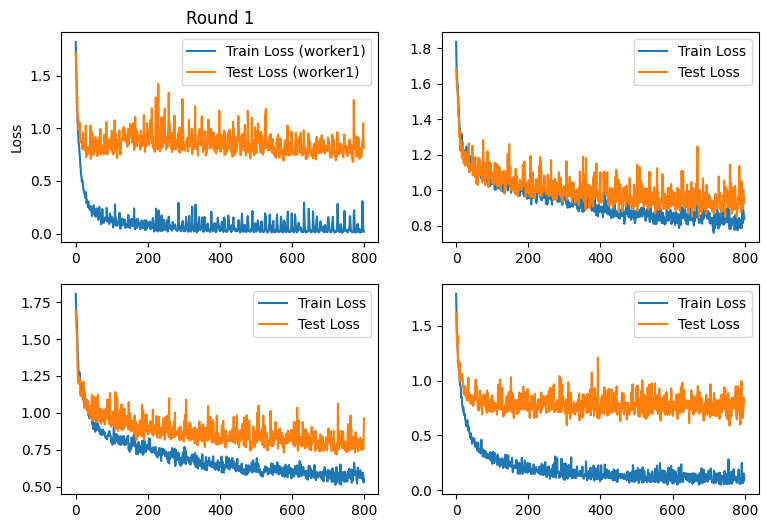

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# Plot train and test loss on first subplot
sns.lineplot(x=range(800), y=train_loss01[:800], label="Train Loss", ax=axs[0,0])
sns.lineplot(x=range(800), y=test_loss01[:800], label="Test Loss", ax=axs[0,0])
axs[0,0].set_title("Round 1")
##axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
legend = axs[0,0].legend()
legend.texts[0].set_text("Train Loss (worker1)")
legend.texts[1].set_text("Test Loss (worker1)")

sns.lineplot(x=range(800), y=train_loss05[:800], label="Train Loss", ax=axs[0,1])
sns.lineplot(x=range(800), y=test_loss05[:800], label="Test Loss", ax=axs[0,1])

sns.lineplot(x=range(800), y=train_loss04[:800], label="Train Loss", ax=axs[1,0])
sns.lineplot(x=range(800), y=test_loss04[:800], label="Test Loss", ax=axs[1,0])

sns.lineplot(x=range(800), y=train_loss02[:800], label="Train Loss", ax=axs[1,1])
sns.lineplot(x=range(800), y=test_loss02[:800], label="Test Loss", ax=axs[1,1])

C:\Users\nazmul_hossen\AppData\Local\Temp\ipykernel_38424\2458474067.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


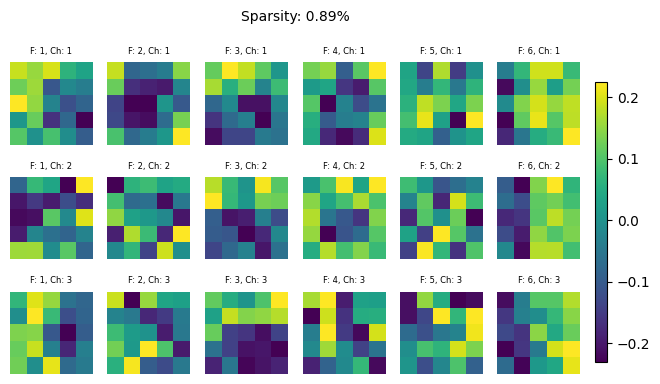

In [29]:
weights_tensor_spr01 = model_spr01.conv1.weight.data
weights_array_spr01 = weights_tensor_spr01.cpu().numpy()
threshold = 1e-30
num_nonzeros = np.count_nonzero(np.abs(weights_array_spr01) >= threshold)
sparsity = 1 - num_nonzeros / weights_array_spr01.size

num_filters, num_channels, filter_size, _ = weights_array_spr01.shape

fig, axs = plt.subplots(nrows=num_channels, ncols=num_filters, figsize=(6, 4))
fig.suptitle(f'Sparsity: {sparsity:.2%}', fontsize=10)

for i in range(num_filters):
    for j in range(num_channels):
        w = weights_array_spr01[i, j]
        if np.max(np.abs(w)) >= threshold:
            im = axs[j, i].imshow(w, cmap='viridis')
            axs[j, i].axis('off')
            axs[j, i].set_title(f'F: {i+1}, Ch: {j+1}' , fontsize=6)

cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.show()

C:\Users\nazmul_hossen\AppData\Local\Temp\ipykernel_38424\2775450018.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


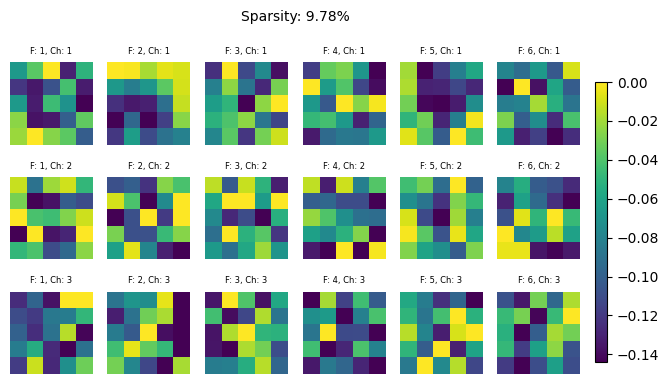

In [39]:
weights_tensor_spr05 = model_spr05.conv1.weight.data
weights_array_spr05 = weights_tensor_spr05.cpu().numpy()
threshold = 1e-30
num_nonzeros = np.count_nonzero(np.abs(weights_array_spr05) >= threshold)
sparsity = 1 - num_nonzeros / weights_array_spr05.size

num_filters, num_channels, filter_size, _ = weights_array_spr05.shape

fig, axs = plt.subplots(nrows=num_channels, ncols=num_filters, figsize=(6, 4))
fig.suptitle(f'Sparsity: {sparsity:.2%}', fontsize=10)

for i in range(num_filters):
    for j in range(num_channels):
        w = weights_array_spr05[i, j]
        if np.max(np.abs(w)) >= threshold:
            im = axs[j, i].imshow(w, cmap='viridis')
            axs[j, i].axis('off')
            axs[j, i].set_title(f'F: {i+1}, Ch: {j+1}' , fontsize=6)

cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.show()

C:\Users\nazmul_hossen\AppData\Local\Temp\ipykernel_38424\3500980525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


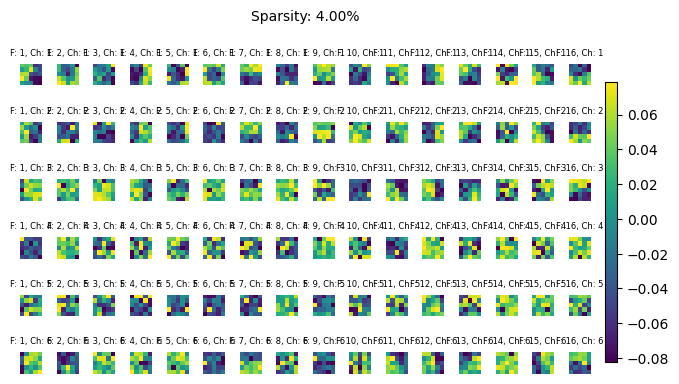

In [49]:
weights_tensor_spr04 = model_spr04.conv2.weight.data
weights_array_spr04 = weights_tensor_spr04.cpu().numpy()
threshold = 1e-30
num_nonzeros = np.count_nonzero(np.abs(weights_array_spr04) >= threshold)
sparsity = 1 - num_nonzeros / weights_array_spr04.size

num_filters, num_channels, filter_size, _ = weights_array_spr04.shape

fig, axs = plt.subplots(nrows=num_channels, ncols=num_filters, figsize=(6, 4))
fig.suptitle(f'Sparsity: {sparsity:.2%}', fontsize=10)

for i in range(num_filters):
    for j in range(num_channels):
        w = weights_array_spr04[i, j]
        if np.max(np.abs(w)) >= threshold:
            im = axs[j, i].imshow(w, cmap='viridis')
            axs[j, i].axis('off')
            axs[j, i].set_title(f'F: {i+1}, Ch: {j+1}' , fontsize=6)

cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.show()

C:\Users\nazmul_hossen\AppData\Local\Temp\ipykernel_4016\107756626.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


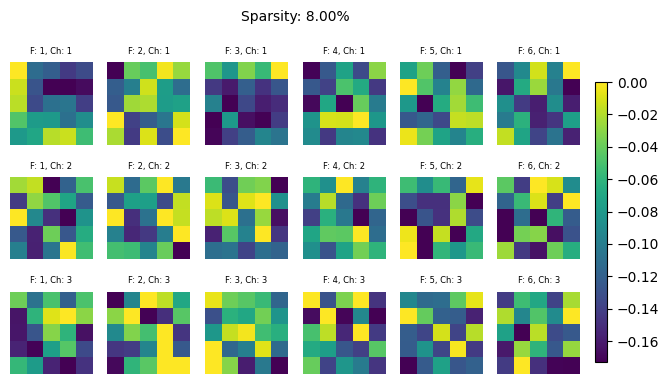

In [120]:
weights_tensor_spr04 = model_spr04.conv1.weight.data
weights_array_spr04 = weights_tensor_spr04.cpu().numpy()
threshold = 1e-30
num_nonzeros = np.count_nonzero(np.abs(weights_array_spr04) >= threshold)
sparsity = 1 - num_nonzeros / weights_array_spr04.size

num_filters, num_channels, filter_size, _ = weights_array_spr04.shape

fig, axs = plt.subplots(nrows=num_channels, ncols=num_filters, figsize=(6, 4))
fig.suptitle(f'Sparsity: {sparsity:.2%}', fontsize=10)

for i in range(num_filters):
    for j in range(num_channels):
        w = weights_array_spr04[i, j]
        if np.max(np.abs(w)) >= threshold:
            im = axs[j, i].imshow(w, cmap='viridis')
            axs[j, i].axis('off')
            axs[j, i].set_title(f'F: {i+1}, Ch: {j+1}' , fontsize=6)

cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.show()

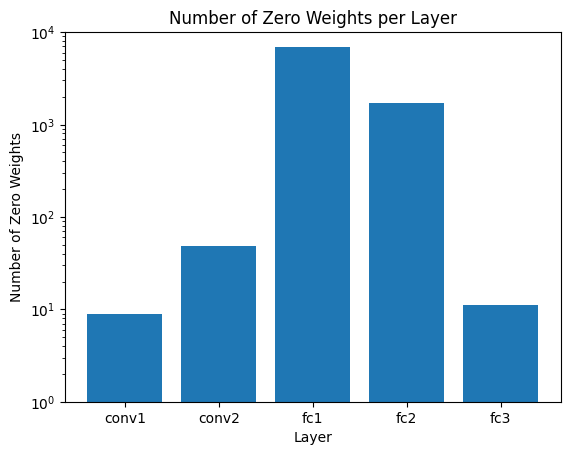

In [84]:
sparsity_values = [0.02, 0.02, 0.02, 0.02, 0.02]
zero_weights = [4, 24, 4520, 1022, 5]
layer_names = ['conv1', 'conv2', 'fc1', 'fc2', 'fc3']

plt.bar(layer_names, zero_weights)
plt.title('Number of Zero Weights per Layer')
plt.xlabel('Layer')
plt.ylabel('Number of Zero Weights')
plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000])

plt.show()


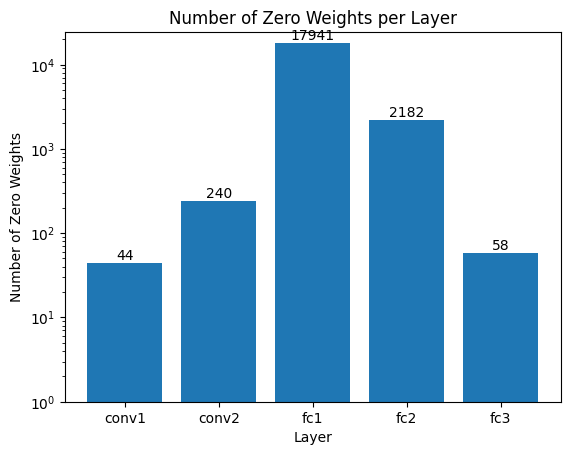

In [44]:
sparsity_values = [0.10, 0.10, 0.06, 0.22, 0.10]
zero_weights = [44, 240, 17941, 2182, 58]
layer_names = ['conv1', 'conv2', 'fc1', 'fc2', 'fc3']

fig, ax = plt.subplots()

bars = ax.bar(layer_names, zero_weights)
plt.title('Number of Zero Weights per Layer')
plt.xlabel('Layer')
plt.ylabel('Number of Zero Weights')
plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000])

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            '%d' % int(height),
            ha='center', va='bottom')

plt.show()


# Pruning sparsity

In [51]:
# Define LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*13*13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,7)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def magnitude_pruning(self, pruning_factor, prune_bias=True):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                # Calculate threshold for current layer
                params = module.weight.cpu().detach().numpy().flatten()
                if prune_bias and module.bias is not None:
                    params = np.concatenate((params, module.bias.cpu().detach().numpy().flatten()))
                threshold = np.percentile(np.abs(params), pruning_factor)

                # Prune weights below threshold
                module.weight.data[torch.abs(module.weight.data) < threshold] = 0
                if module.bias is not None:
                    module.bias.data[torch.abs(module.bias.data) < threshold] = 0
                    
    def random_pruning(self, pruning_factor, prune_bias=True):
        params = []
        for p in self.parameters():
            if len(p.data.size()) != 1:
                params += list(p.cpu().data.abs().numpy().flatten())
                #num_prune = int(pruning_factor * len(params))
                num_prune = min(int(pruning_factor * len(params)), sum(1 for _ in p.data.flatten() if _ != 0))
            # Randomly select weights to prune
        #idx = np.random.permutation(len(params))[:num_prune]
        idx = np.random.choice(len(params), size=num_prune, replace=False)
        cnt = 0
        for p in self.parameters():
            if len(p.data.size()) != 1:
                numel = p.data.numel()
                if cnt + numel <= idx[-1]:
                    cnt += numel
                    continue
                p.data.view(-1)[idx[cnt:(idx >= cnt + numel).argmax() + cnt]] = 0
                cnt += numel


In [34]:
def magnitude_pruning(model, pruning_factor):
        # Calculate threshold
        params = []
        for p in model.parameters():
            if len(p.data.size()) != 1:
                params += list(p.cpu().data.abs().numpy().flatten())
                threshold = np.percentile(np.array(params), pruning_factor)

        # Prune weights below threshold
        for p in model.parameters():
            if len(p.data.size()) != 1:
                p.data[p.data.abs() < threshold] = 0
        

In [61]:
# Define random pruning function
def random_pruning(model, pruning_factor):
    params = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            params += list(p.cpu().data.abs().numpy().flatten())
            #num_prune = int(pruning_factor * len(params))
            num_prune = min(int(pruning_factor * len(params)), sum(1 for _ in p.data.flatten() if _ != 0))
        # Randomly select weights to prune
    #idx = np.random.permutation(len(params))[:num_prune]
    idx = np.random.choice(len(params), size=num_prune, replace=False)
    cnt = 0
    for p in model.parameters():
        if len(p.data.size()) != 1:
            numel = p.data.numel()
            if cnt + numel <= idx[-1]:
                cnt += numel
                continue
            p.data.view(-1)[idx[cnt:(idx >= cnt + numel).argmax() + cnt]] = 0
            cnt += numel

In [82]:
# Define structured pruning function
def structured_pruning(model, pruning_factor):
    # Calculate number of weights to prune per layer
    total_params = sum(p.numel() for p in model.parameters() if len(p.data.size()) != 1)
    num_prune = int(pruning_factor * total_params / 100)
    layer_params = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            layer_params.append(p.numel())
            layer_prune = np.round(np.cumsum(layer_params) / np.sum(layer_params) * num_prune).astype(int)
            layer_prune[-1] = num_prune
    # Prune weights in each layer
    cnt = 0
    for p in model.parameters():
        if len(p.data.size()) != 1:
            numel = p.data.numel()
            if cnt >= num_prune:
                p.data = torch.zeros_like(p.data)

In [50]:
# Create LeNet model
model = LeNet()

# Perform magnitude pruning with pruning_factor=50 and prune_bias=True
model.magnitude_pruning(50, True)

In [53]:
model_rp40 = LeNet()

# Perform magnitude pruning with pruning_factor=50 and prune_bias=True
model_rp40.random_pruning(40, True)

In [54]:
import torch.optim as optim
import torch.nn.functional as F

#model.train()
train_loss = 0
train_correct = 0
lambda_l2 = 0.03
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rp40.parameters(), lr=0.001, weight_decay=lambda_l2)
num_epochs = 500
pruning_factor = 40
train_loss_rp40 = []
test_loss_rp40 = []
acc_rp40 = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model_rp40(inputs)
        loss = criterion(outputs, labels.long())
            
        l2_reg = sum(torch.norm(param) for param in model_rp40.parameters())
        loss += lambda_l2 * l2_reg
            
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    _train_loss = running_loss / len(train_dataloader)
    train_loss_rp40.append(_train_loss)

    running_test_loss = 0.0
    model_rp40.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            inputs, targets = batch
            outputs = model_rp40(inputs)
            loss = criterion(outputs, targets.long())
            running_test_loss += loss.item()
    _test_loss = running_test_loss / len(test_dataloader)
    test_loss_rp40.append(_test_loss)

    print('Epoch [%d], train_loss: %.3f, test_loss: %.3f' % (epoch + 1, _train_loss, _test_loss))
    #model.magnitude_pruning(pruning_factor)

    # Evaluate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            outputs = model_rp40(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    _acc = correct / total
    acc_rp40.append(_acc)

    print('Accuracy: %d %%' % (100 * correct / total))
    #return train_loss_list, test_loss_list, acc_list,model

Epoch [1], train_loss: 2.165, test_loss: 1.749
Accuracy: 26 %
Epoch [2], train_loss: 1.939, test_loss: 1.731
Accuracy: 27 %
Epoch [3], train_loss: 1.898, test_loss: 1.734
Accuracy: 25 %
Epoch [4], train_loss: 1.873, test_loss: 1.728
Accuracy: 27 %
Epoch [5], train_loss: 1.866, test_loss: 1.716
Accuracy: 28 %
Epoch [6], train_loss: 1.842, test_loss: 1.736
Accuracy: 25 %
Epoch [7], train_loss: 1.834, test_loss: 1.714
Accuracy: 27 %
Epoch [8], train_loss: 1.841, test_loss: 1.718
Accuracy: 26 %
Epoch [9], train_loss: 1.826, test_loss: 1.685
Accuracy: 27 %
Epoch [10], train_loss: 1.813, test_loss: 1.693
Accuracy: 26 %
Epoch [11], train_loss: 1.800, test_loss: 1.662
Accuracy: 30 %
Epoch [12], train_loss: 1.797, test_loss: 1.659
Accuracy: 29 %
Epoch [13], train_loss: 1.789, test_loss: 1.710
Accuracy: 29 %
Epoch [14], train_loss: 1.784, test_loss: 1.623
Accuracy: 31 %
Epoch [15], train_loss: 1.753, test_loss: 1.606
Accuracy: 31 %
Epoch [16], train_loss: 1.750, test_loss: 1.589
Accuracy: 33 %
E

Epoch [131], train_loss: 1.129, test_loss: 1.009
Accuracy: 61 %
Epoch [132], train_loss: 1.191, test_loss: 1.009
Accuracy: 62 %
Epoch [133], train_loss: 1.137, test_loss: 0.988
Accuracy: 64 %
Epoch [134], train_loss: 1.128, test_loss: 0.955
Accuracy: 63 %
Epoch [135], train_loss: 1.129, test_loss: 0.991
Accuracy: 63 %
Epoch [136], train_loss: 1.127, test_loss: 0.956
Accuracy: 65 %
Epoch [137], train_loss: 1.110, test_loss: 0.999
Accuracy: 64 %
Epoch [138], train_loss: 1.115, test_loss: 1.073
Accuracy: 60 %
Epoch [139], train_loss: 1.129, test_loss: 0.947
Accuracy: 64 %
Epoch [140], train_loss: 1.103, test_loss: 0.979
Accuracy: 64 %
Epoch [141], train_loss: 1.121, test_loss: 0.957
Accuracy: 64 %
Epoch [142], train_loss: 1.093, test_loss: 0.942
Accuracy: 65 %
Epoch [143], train_loss: 1.075, test_loss: 0.944
Accuracy: 66 %
Epoch [144], train_loss: 1.098, test_loss: 0.941
Accuracy: 64 %
Epoch [145], train_loss: 1.124, test_loss: 0.935
Accuracy: 65 %
Epoch [146], train_loss: 1.090, test_los

Epoch [260], train_loss: 0.831, test_loss: 0.802
Accuracy: 75 %
Epoch [261], train_loss: 0.838, test_loss: 0.894
Accuracy: 73 %
Epoch [262], train_loss: 0.835, test_loss: 0.827
Accuracy: 74 %
Epoch [263], train_loss: 0.825, test_loss: 0.858
Accuracy: 73 %
Epoch [264], train_loss: 0.820, test_loss: 0.833
Accuracy: 72 %
Epoch [265], train_loss: 0.831, test_loss: 0.798
Accuracy: 75 %
Epoch [266], train_loss: 0.813, test_loss: 0.812
Accuracy: 73 %
Epoch [267], train_loss: 0.810, test_loss: 0.899
Accuracy: 72 %
Epoch [268], train_loss: 0.847, test_loss: 0.842
Accuracy: 73 %
Epoch [269], train_loss: 0.833, test_loss: 0.820
Accuracy: 74 %
Epoch [270], train_loss: 0.811, test_loss: 0.840
Accuracy: 74 %
Epoch [271], train_loss: 0.830, test_loss: 0.928
Accuracy: 71 %
Epoch [272], train_loss: 0.833, test_loss: 0.837
Accuracy: 71 %
Epoch [273], train_loss: 0.808, test_loss: 0.857
Accuracy: 73 %
Epoch [274], train_loss: 0.800, test_loss: 0.833
Accuracy: 75 %
Epoch [275], train_loss: 0.802, test_los

Epoch [389], train_loss: 0.675, test_loss: 0.806
Accuracy: 76 %
Epoch [390], train_loss: 0.721, test_loss: 0.857
Accuracy: 74 %
Epoch [391], train_loss: 0.690, test_loss: 0.872
Accuracy: 76 %
Epoch [392], train_loss: 0.675, test_loss: 0.857
Accuracy: 74 %
Epoch [393], train_loss: 0.705, test_loss: 1.170
Accuracy: 64 %
Epoch [394], train_loss: 0.754, test_loss: 0.865
Accuracy: 74 %
Epoch [395], train_loss: 0.684, test_loss: 0.835
Accuracy: 74 %
Epoch [396], train_loss: 0.681, test_loss: 0.846
Accuracy: 76 %
Epoch [397], train_loss: 0.736, test_loss: 0.888
Accuracy: 73 %
Epoch [398], train_loss: 0.666, test_loss: 0.881
Accuracy: 75 %
Epoch [399], train_loss: 0.663, test_loss: 0.811
Accuracy: 76 %
Epoch [400], train_loss: 0.678, test_loss: 0.906
Accuracy: 74 %
Epoch [401], train_loss: 0.691, test_loss: 0.846
Accuracy: 75 %
Epoch [402], train_loss: 0.699, test_loss: 0.844
Accuracy: 75 %
Epoch [403], train_loss: 0.677, test_loss: 0.933
Accuracy: 72 %
Epoch [404], train_loss: 0.699, test_los

# Model param count

In [43]:
def count_trainable_params(model_param):
    count = 0
    for p in model_param.parameters():
        if p.requires_grad:
            count += p.numel()
    return count

# Model computational cost count

In [50]:
# Define the input shape (batch_size, in_channels, in_h, in_w)
input_shape = (30, 3, 64, 64)

# Iterate through the model's layers and count FLOPs for each layer
total_flops = 0
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        flops = count_flops_conv2d(layer, input_shape)
        print(f"FLOPs for {name}: {flops}")
        total_flops += flops
    elif isinstance(layer, nn.Linear):
        # Calculate the input shape for linear layer based on the output shape of the previous layer
        in_features = layer.in_features
        batch_size = input_shape[0]
        flops = count_flops_linear(layer, (batch_size, in_features))
        print(f"FLOPs for {name}: {flops}")
        total_flops += flops
    if isinstance(layer, nn.MaxPool2d):
        input_shape = (input_shape[0], input_shape[1], input_shape[2]//2, input_shape[3]//2)

print(f"Total FLOPs: {total_flops}")

FLOPs for conv1: 97200000
FLOPs for conv2: 56448000
FLOPs for fc1: 19468800
FLOPs for fc2: 604800
FLOPs for fc3: 35280
Total FLOPs: 173756880


In [60]:
# Define the input shape (batch_size, in_channels, in_h, in_w)
input_shape = (30, 3, 64, 64)

# Iterate through the model's layers and count FLOPs for each layer
total_flops = 0
for name, layer in model_rp40.named_modules():
    if isinstance(layer, nn.Conv2d):
        flops = count_flops_conv2d(layer, input_shape)
        print(f"FLOPs for {name}: {flops}")
        total_flops += flops
    elif isinstance(layer, nn.Linear):
        # Calculate the input shape for linear layer based on the output shape of the previous layer
        in_features = layer.in_features
        batch_size = input_shape[0]
        flops = count_flops_linear(layer, (batch_size, in_features))
        print(f"FLOPs for {name}: {flops}")
        total_flops += flops
    if isinstance(layer, nn.MaxPool2d):
        input_shape = (input_shape[0], input_shape[1], input_shape[2]//2, input_shape[3]//2)

print(f"Total FLOPs: {total_flops}")

FLOPs for conv1: 97200000
FLOPs for conv2: 56448000
FLOPs for fc1: 19468800
FLOPs for fc2: 604800
FLOPs for fc3: 35280
Total FLOPs: 173756880


In [46]:
model_rp_param = count_trainable_params(model_rp50)
print(model_rp_param)

338231


In [59]:
model_rp_param = count_trainable_params(model_rp40)
print(model_rp_param)

338231


In [47]:
model_rp_param = count_trainable_params(LeNet())
print(model_rp_param)

338231


In [31]:
model = LeNet()

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = F.cross_entropy

In [48]:
print('Training model without pruning...')
model = LeNet()
train_loss_wp, test_loss_wp = train(1000, model, train_dataloader, test_dataloader)

Training model without pruning...
Epoch [1], train_loss: 2.196, test_loss: 1.871
Accuracy: 22 %
Epoch [2], train_loss: 1.977, test_loss: 1.758
Accuracy: 24 %
Epoch [3], train_loss: 1.885, test_loss: 1.729
Accuracy: 26 %
Epoch [4], train_loss: 1.876, test_loss: 1.742
Accuracy: 25 %
Epoch [5], train_loss: 1.862, test_loss: 1.730
Accuracy: 27 %
Epoch [6], train_loss: 1.851, test_loss: 1.722
Accuracy: 26 %
Epoch [7], train_loss: 1.848, test_loss: 1.723
Accuracy: 26 %
Epoch [8], train_loss: 1.844, test_loss: 1.747
Accuracy: 25 %
Epoch [9], train_loss: 1.851, test_loss: 1.722
Accuracy: 27 %
Epoch [10], train_loss: 1.828, test_loss: 1.715
Accuracy: 29 %
Epoch [11], train_loss: 1.844, test_loss: 1.712
Accuracy: 26 %
Epoch [12], train_loss: 1.839, test_loss: 1.711
Accuracy: 25 %
Epoch [13], train_loss: 1.826, test_loss: 1.710
Accuracy: 28 %
Epoch [14], train_loss: 1.842, test_loss: 1.712
Accuracy: 27 %
Epoch [15], train_loss: 1.819, test_loss: 1.700
Accuracy: 26 %
Epoch [16], train_loss: 1.815,

Epoch [131], train_loss: 1.182, test_loss: 1.071
Accuracy: 59 %
Epoch [132], train_loss: 1.185, test_loss: 1.050
Accuracy: 60 %
Epoch [133], train_loss: 1.193, test_loss: 1.010
Accuracy: 63 %
Epoch [134], train_loss: 1.212, test_loss: 1.006
Accuracy: 63 %
Epoch [135], train_loss: 1.184, test_loss: 1.014
Accuracy: 61 %
Epoch [136], train_loss: 1.187, test_loss: 0.979
Accuracy: 65 %
Epoch [137], train_loss: 1.150, test_loss: 0.982
Accuracy: 64 %
Epoch [138], train_loss: 1.152, test_loss: 0.976
Accuracy: 63 %
Epoch [139], train_loss: 1.142, test_loss: 0.995
Accuracy: 62 %
Epoch [140], train_loss: 1.148, test_loss: 0.982
Accuracy: 60 %
Epoch [141], train_loss: 1.155, test_loss: 0.985
Accuracy: 64 %
Epoch [142], train_loss: 1.167, test_loss: 0.968
Accuracy: 61 %
Epoch [143], train_loss: 1.146, test_loss: 0.973
Accuracy: 63 %
Epoch [144], train_loss: 1.132, test_loss: 0.962
Accuracy: 64 %
Epoch [145], train_loss: 1.123, test_loss: 0.942
Accuracy: 66 %
Epoch [146], train_loss: 1.117, test_los

Epoch [260], train_loss: 0.827, test_loss: 0.841
Accuracy: 72 %
Epoch [261], train_loss: 0.848, test_loss: 0.800
Accuracy: 73 %
Epoch [262], train_loss: 0.795, test_loss: 0.975
Accuracy: 68 %
Epoch [263], train_loss: 0.830, test_loss: 0.799
Accuracy: 72 %
Epoch [264], train_loss: 0.804, test_loss: 0.812
Accuracy: 74 %
Epoch [265], train_loss: 0.831, test_loss: 0.819
Accuracy: 72 %
Epoch [266], train_loss: 0.868, test_loss: 0.878
Accuracy: 69 %
Epoch [267], train_loss: 0.817, test_loss: 0.795
Accuracy: 72 %
Epoch [268], train_loss: 0.791, test_loss: 0.770
Accuracy: 74 %
Epoch [269], train_loss: 0.810, test_loss: 0.807
Accuracy: 73 %
Epoch [270], train_loss: 0.811, test_loss: 0.811
Accuracy: 76 %
Epoch [271], train_loss: 0.789, test_loss: 0.855
Accuracy: 70 %
Epoch [272], train_loss: 0.840, test_loss: 0.807
Accuracy: 74 %
Epoch [273], train_loss: 0.797, test_loss: 0.805
Accuracy: 73 %
Epoch [274], train_loss: 0.814, test_loss: 0.823
Accuracy: 73 %
Epoch [275], train_loss: 0.834, test_los

Epoch [389], train_loss: 0.723, test_loss: 0.772
Accuracy: 77 %
Epoch [390], train_loss: 0.753, test_loss: 0.840
Accuracy: 75 %
Epoch [391], train_loss: 0.751, test_loss: 0.912
Accuracy: 72 %
Epoch [392], train_loss: 0.760, test_loss: 0.780
Accuracy: 75 %
Epoch [393], train_loss: 0.739, test_loss: 0.988
Accuracy: 70 %
Epoch [394], train_loss: 0.745, test_loss: 0.817
Accuracy: 74 %
Epoch [395], train_loss: 0.731, test_loss: 0.863
Accuracy: 73 %
Epoch [396], train_loss: 0.748, test_loss: 0.828
Accuracy: 76 %
Epoch [397], train_loss: 0.745, test_loss: 0.756
Accuracy: 77 %
Epoch [398], train_loss: 0.723, test_loss: 0.777
Accuracy: 74 %
Epoch [399], train_loss: 0.693, test_loss: 0.840
Accuracy: 77 %
Epoch [400], train_loss: 0.728, test_loss: 0.864
Accuracy: 73 %
Epoch [401], train_loss: 0.733, test_loss: 0.864
Accuracy: 72 %
Epoch [402], train_loss: 0.751, test_loss: 0.798
Accuracy: 75 %
Epoch [403], train_loss: 0.752, test_loss: 0.769
Accuracy: 79 %
Epoch [404], train_loss: 0.725, test_los

Epoch [518], train_loss: 0.732, test_loss: 0.821
Accuracy: 72 %
Epoch [519], train_loss: 0.776, test_loss: 0.833
Accuracy: 75 %
Epoch [520], train_loss: 0.689, test_loss: 0.823
Accuracy: 74 %
Epoch [521], train_loss: 0.734, test_loss: 0.790
Accuracy: 77 %
Epoch [522], train_loss: 0.680, test_loss: 0.746
Accuracy: 76 %
Epoch [523], train_loss: 0.726, test_loss: 0.741
Accuracy: 79 %
Epoch [524], train_loss: 0.668, test_loss: 0.784
Accuracy: 77 %
Epoch [525], train_loss: 0.662, test_loss: 0.835
Accuracy: 76 %
Epoch [526], train_loss: 0.684, test_loss: 0.806
Accuracy: 76 %
Epoch [527], train_loss: 0.674, test_loss: 0.857
Accuracy: 77 %
Epoch [528], train_loss: 0.676, test_loss: 0.791
Accuracy: 77 %
Epoch [529], train_loss: 0.701, test_loss: 0.791
Accuracy: 77 %
Epoch [530], train_loss: 0.714, test_loss: 0.858
Accuracy: 74 %
Epoch [531], train_loss: 0.689, test_loss: 0.778
Accuracy: 77 %
Epoch [532], train_loss: 0.663, test_loss: 0.776
Accuracy: 79 %
Epoch [533], train_loss: 0.705, test_los

Epoch [647], train_loss: 0.663, test_loss: 0.857
Accuracy: 75 %
Epoch [648], train_loss: 0.665, test_loss: 0.911
Accuracy: 76 %
Epoch [649], train_loss: 0.661, test_loss: 0.789
Accuracy: 76 %
Epoch [650], train_loss: 0.642, test_loss: 0.784
Accuracy: 78 %
Epoch [651], train_loss: 0.646, test_loss: 0.793
Accuracy: 76 %
Epoch [652], train_loss: 0.697, test_loss: 0.805
Accuracy: 76 %
Epoch [653], train_loss: 0.658, test_loss: 0.842
Accuracy: 78 %
Epoch [654], train_loss: 0.650, test_loss: 0.933
Accuracy: 74 %
Epoch [655], train_loss: 0.654, test_loss: 0.799
Accuracy: 80 %
Epoch [656], train_loss: 0.659, test_loss: 0.799
Accuracy: 78 %
Epoch [657], train_loss: 0.669, test_loss: 0.782
Accuracy: 77 %
Epoch [658], train_loss: 0.671, test_loss: 0.844
Accuracy: 73 %
Epoch [659], train_loss: 0.696, test_loss: 0.790
Accuracy: 77 %
Epoch [660], train_loss: 0.710, test_loss: 0.888
Accuracy: 71 %
Epoch [661], train_loss: 0.729, test_loss: 0.859
Accuracy: 74 %
Epoch [662], train_loss: 0.668, test_los

Epoch [776], train_loss: 0.677, test_loss: 0.824
Accuracy: 78 %
Epoch [777], train_loss: 0.641, test_loss: 0.830
Accuracy: 76 %
Epoch [778], train_loss: 0.628, test_loss: 0.797
Accuracy: 78 %
Epoch [779], train_loss: 0.626, test_loss: 0.802
Accuracy: 78 %
Epoch [780], train_loss: 0.640, test_loss: 0.852
Accuracy: 75 %
Epoch [781], train_loss: 0.626, test_loss: 0.793
Accuracy: 78 %
Epoch [782], train_loss: 0.659, test_loss: 0.868
Accuracy: 76 %
Epoch [783], train_loss: 0.669, test_loss: 0.763
Accuracy: 80 %
Epoch [784], train_loss: 0.660, test_loss: 0.841
Accuracy: 78 %
Epoch [785], train_loss: 0.642, test_loss: 0.818
Accuracy: 77 %
Epoch [786], train_loss: 0.649, test_loss: 0.807
Accuracy: 77 %
Epoch [787], train_loss: 0.617, test_loss: 0.858
Accuracy: 79 %
Epoch [788], train_loss: 0.647, test_loss: 0.847
Accuracy: 77 %
Epoch [789], train_loss: 0.649, test_loss: 0.836
Accuracy: 77 %
Epoch [790], train_loss: 0.656, test_loss: 0.889
Accuracy: 76 %
Epoch [791], train_loss: 0.631, test_los

Epoch [905], train_loss: 0.644, test_loss: 0.803
Accuracy: 78 %
Epoch [906], train_loss: 0.650, test_loss: 0.798
Accuracy: 76 %
Epoch [907], train_loss: 0.661, test_loss: 0.816
Accuracy: 78 %
Epoch [908], train_loss: 0.631, test_loss: 0.837
Accuracy: 76 %
Epoch [909], train_loss: 0.631, test_loss: 0.814
Accuracy: 77 %
Epoch [910], train_loss: 0.700, test_loss: 0.853
Accuracy: 77 %
Epoch [911], train_loss: 0.671, test_loss: 0.828
Accuracy: 77 %
Epoch [912], train_loss: 0.650, test_loss: 0.780
Accuracy: 79 %
Epoch [913], train_loss: 0.621, test_loss: 0.797
Accuracy: 78 %
Epoch [914], train_loss: 0.626, test_loss: 0.829
Accuracy: 77 %
Epoch [915], train_loss: 0.631, test_loss: 0.768
Accuracy: 78 %
Epoch [916], train_loss: 0.612, test_loss: 0.773
Accuracy: 79 %
Epoch [917], train_loss: 0.692, test_loss: 0.812
Accuracy: 79 %
Epoch [918], train_loss: 0.657, test_loss: 0.864
Accuracy: 76 %
Epoch [919], train_loss: 0.651, test_loss: 0.819
Accuracy: 77 %
Epoch [920], train_loss: 0.639, test_los

In [106]:
print('Magnitude pruning...')
pruning_factor = 40
model = LeNet()
#magnitude_pruning(model,pruning_factor)
train_loss_mp, test_loss_mp, acc_mp, model_mp = train(10, pruning_factor, model, train_dataloader, test_dataloader)

Magnitude pruning...
Epoch [1], train_loss: 2.204, test_loss: 1.767
Accuracy: 20 %
Epoch [2], train_loss: 1.941, test_loss: 1.738
Accuracy: 27 %
Epoch [3], train_loss: 1.884, test_loss: 1.722
Accuracy: 29 %
Epoch [4], train_loss: 1.868, test_loss: 1.729
Accuracy: 26 %
Epoch [5], train_loss: 1.849, test_loss: 1.752
Accuracy: 23 %
Epoch [6], train_loss: 1.853, test_loss: 1.730
Accuracy: 24 %
Epoch [7], train_loss: 1.850, test_loss: 1.718
Accuracy: 28 %
Epoch [8], train_loss: 1.833, test_loss: 1.725
Accuracy: 26 %
Epoch [9], train_loss: 1.832, test_loss: 1.726
Accuracy: 24 %
Epoch [10], train_loss: 1.833, test_loss: 1.719
Accuracy: 29 %


In [110]:
if torch.allclose(model.conv1.weight.data, model_mp.conv1.weight.data):
    print("The tensors are element-wise equal") 

The tensors are element-wise equal


In [79]:
print('Random pruning...')
pruning_factor = 50
model = LeNet()  # reset model weights
random_pruning(model,pruning_factor)
train_loss_rp, test_loss_rp, acc_rp = train(2000, model, train_dataloader, test_dataloader)

Random pruning...
Epoch [1], train_loss: 2.215, test_loss: 1.776
Accuracy: 25 %
Epoch [2], train_loss: 1.941, test_loss: 1.715
Accuracy: 24 %
Epoch [3], train_loss: 1.876, test_loss: 1.703
Accuracy: 28 %
Epoch [4], train_loss: 1.842, test_loss: 1.691
Accuracy: 28 %
Epoch [5], train_loss: 1.820, test_loss: 1.667
Accuracy: 30 %
Epoch [6], train_loss: 1.797, test_loss: 1.649
Accuracy: 29 %
Epoch [7], train_loss: 1.783, test_loss: 1.623
Accuracy: 30 %
Epoch [8], train_loss: 1.765, test_loss: 1.600
Accuracy: 32 %
Epoch [9], train_loss: 1.734, test_loss: 1.549
Accuracy: 34 %
Epoch [10], train_loss: 1.721, test_loss: 1.528
Accuracy: 32 %
Epoch [11], train_loss: 1.691, test_loss: 1.531
Accuracy: 36 %
Epoch [12], train_loss: 1.671, test_loss: 1.487
Accuracy: 33 %
Epoch [13], train_loss: 1.652, test_loss: 1.478
Accuracy: 38 %
Epoch [14], train_loss: 1.628, test_loss: 1.447
Accuracy: 38 %
Epoch [15], train_loss: 1.638, test_loss: 1.434
Accuracy: 37 %
Epoch [16], train_loss: 1.606, test_loss: 1.41

Epoch [131], train_loss: 0.974, test_loss: 0.951
Accuracy: 66 %
Epoch [132], train_loss: 0.989, test_loss: 0.890
Accuracy: 69 %
Epoch [133], train_loss: 0.952, test_loss: 0.827
Accuracy: 71 %
Epoch [134], train_loss: 0.992, test_loss: 0.842
Accuracy: 70 %
Epoch [135], train_loss: 0.956, test_loss: 0.858
Accuracy: 69 %
Epoch [136], train_loss: 0.940, test_loss: 0.857
Accuracy: 70 %
Epoch [137], train_loss: 0.959, test_loss: 0.814
Accuracy: 69 %
Epoch [138], train_loss: 0.938, test_loss: 0.885
Accuracy: 72 %
Epoch [139], train_loss: 0.955, test_loss: 0.847
Accuracy: 69 %
Epoch [140], train_loss: 0.971, test_loss: 0.895
Accuracy: 68 %
Epoch [141], train_loss: 0.938, test_loss: 0.811
Accuracy: 69 %
Epoch [142], train_loss: 0.929, test_loss: 0.812
Accuracy: 71 %
Epoch [143], train_loss: 0.941, test_loss: 0.836
Accuracy: 71 %
Epoch [144], train_loss: 0.927, test_loss: 0.975
Accuracy: 65 %
Epoch [145], train_loss: 0.948, test_loss: 0.909
Accuracy: 67 %
Epoch [146], train_loss: 0.939, test_los

Epoch [260], train_loss: 0.735, test_loss: 0.823
Accuracy: 76 %
Epoch [261], train_loss: 0.707, test_loss: 0.767
Accuracy: 74 %
Epoch [262], train_loss: 0.717, test_loss: 0.771
Accuracy: 76 %
Epoch [263], train_loss: 0.711, test_loss: 0.774
Accuracy: 75 %
Epoch [264], train_loss: 0.753, test_loss: 0.768
Accuracy: 77 %
Epoch [265], train_loss: 0.731, test_loss: 0.827
Accuracy: 74 %
Epoch [266], train_loss: 0.757, test_loss: 0.757
Accuracy: 75 %
Epoch [267], train_loss: 0.735, test_loss: 0.822
Accuracy: 77 %
Epoch [268], train_loss: 0.731, test_loss: 0.764
Accuracy: 77 %
Epoch [269], train_loss: 0.722, test_loss: 0.751
Accuracy: 76 %
Epoch [270], train_loss: 0.676, test_loss: 0.765
Accuracy: 77 %
Epoch [271], train_loss: 0.740, test_loss: 0.782
Accuracy: 74 %
Epoch [272], train_loss: 0.740, test_loss: 0.758
Accuracy: 76 %
Epoch [273], train_loss: 0.719, test_loss: 0.890
Accuracy: 74 %
Epoch [274], train_loss: 0.762, test_loss: 0.773
Accuracy: 76 %
Epoch [275], train_loss: 0.706, test_los

Epoch [389], train_loss: 0.667, test_loss: 0.808
Accuracy: 76 %
Epoch [390], train_loss: 0.639, test_loss: 0.882
Accuracy: 77 %
Epoch [391], train_loss: 0.706, test_loss: 0.797
Accuracy: 76 %
Epoch [392], train_loss: 0.676, test_loss: 0.816
Accuracy: 76 %
Epoch [393], train_loss: 0.644, test_loss: 0.810
Accuracy: 75 %
Epoch [394], train_loss: 0.649, test_loss: 0.896
Accuracy: 74 %
Epoch [395], train_loss: 0.659, test_loss: 0.835
Accuracy: 75 %
Epoch [396], train_loss: 0.629, test_loss: 0.786
Accuracy: 75 %
Epoch [397], train_loss: 0.654, test_loss: 0.871
Accuracy: 75 %
Epoch [398], train_loss: 0.635, test_loss: 0.791
Accuracy: 75 %
Epoch [399], train_loss: 0.633, test_loss: 0.828
Accuracy: 75 %
Epoch [400], train_loss: 0.652, test_loss: 0.833
Accuracy: 75 %
Epoch [401], train_loss: 0.666, test_loss: 0.802
Accuracy: 76 %
Epoch [402], train_loss: 0.631, test_loss: 0.767
Accuracy: 77 %
Epoch [403], train_loss: 0.638, test_loss: 0.869
Accuracy: 76 %
Epoch [404], train_loss: 0.675, test_los

Epoch [518], train_loss: 0.596, test_loss: 0.760
Accuracy: 77 %
Epoch [519], train_loss: 0.610, test_loss: 0.762
Accuracy: 76 %
Epoch [520], train_loss: 0.622, test_loss: 0.761
Accuracy: 78 %
Epoch [521], train_loss: 0.646, test_loss: 0.904
Accuracy: 75 %
Epoch [522], train_loss: 0.688, test_loss: 0.886
Accuracy: 75 %
Epoch [523], train_loss: 0.685, test_loss: 0.765
Accuracy: 76 %
Epoch [524], train_loss: 0.631, test_loss: 0.823
Accuracy: 76 %
Epoch [525], train_loss: 0.630, test_loss: 0.851
Accuracy: 75 %
Epoch [526], train_loss: 0.615, test_loss: 0.805
Accuracy: 76 %
Epoch [527], train_loss: 0.622, test_loss: 0.780
Accuracy: 78 %
Epoch [528], train_loss: 0.606, test_loss: 0.802
Accuracy: 76 %
Epoch [529], train_loss: 0.638, test_loss: 0.980
Accuracy: 73 %
Epoch [530], train_loss: 0.619, test_loss: 0.739
Accuracy: 79 %
Epoch [531], train_loss: 0.627, test_loss: 0.808
Accuracy: 77 %
Epoch [532], train_loss: 0.643, test_loss: 0.836
Accuracy: 74 %
Epoch [533], train_loss: 0.660, test_los

Epoch [647], train_loss: 0.602, test_loss: 0.771
Accuracy: 77 %
Epoch [648], train_loss: 0.643, test_loss: 0.839
Accuracy: 78 %
Epoch [649], train_loss: 0.610, test_loss: 0.750
Accuracy: 78 %
Epoch [650], train_loss: 0.587, test_loss: 0.770
Accuracy: 78 %
Epoch [651], train_loss: 0.595, test_loss: 0.872
Accuracy: 78 %
Epoch [652], train_loss: 0.592, test_loss: 0.828
Accuracy: 76 %
Epoch [653], train_loss: 0.608, test_loss: 0.831
Accuracy: 78 %
Epoch [654], train_loss: 0.613, test_loss: 0.848
Accuracy: 75 %
Epoch [655], train_loss: 0.623, test_loss: 0.786
Accuracy: 75 %
Epoch [656], train_loss: 0.619, test_loss: 0.829
Accuracy: 77 %
Epoch [657], train_loss: 0.617, test_loss: 0.840
Accuracy: 75 %
Epoch [658], train_loss: 0.625, test_loss: 0.790
Accuracy: 79 %
Epoch [659], train_loss: 0.581, test_loss: 0.775
Accuracy: 78 %
Epoch [660], train_loss: 0.586, test_loss: 0.760
Accuracy: 79 %
Epoch [661], train_loss: 0.611, test_loss: 0.719
Accuracy: 79 %
Epoch [662], train_loss: 0.620, test_los

Epoch [776], train_loss: 0.597, test_loss: 0.806
Accuracy: 77 %
Epoch [777], train_loss: 0.601, test_loss: 0.813
Accuracy: 76 %
Epoch [778], train_loss: 0.576, test_loss: 0.799
Accuracy: 78 %
Epoch [779], train_loss: 0.622, test_loss: 0.886
Accuracy: 73 %
Epoch [780], train_loss: 0.577, test_loss: 0.777
Accuracy: 79 %
Epoch [781], train_loss: 0.592, test_loss: 0.835
Accuracy: 76 %
Epoch [782], train_loss: 0.584, test_loss: 0.808
Accuracy: 79 %
Epoch [783], train_loss: 0.573, test_loss: 0.831
Accuracy: 77 %
Epoch [784], train_loss: 0.620, test_loss: 0.836
Accuracy: 76 %
Epoch [785], train_loss: 0.621, test_loss: 0.844
Accuracy: 76 %
Epoch [786], train_loss: 0.602, test_loss: 0.884
Accuracy: 76 %
Epoch [787], train_loss: 0.598, test_loss: 0.785
Accuracy: 77 %
Epoch [788], train_loss: 0.572, test_loss: 0.830
Accuracy: 77 %
Epoch [789], train_loss: 0.586, test_loss: 0.852
Accuracy: 77 %
Epoch [790], train_loss: 0.596, test_loss: 0.808
Accuracy: 77 %
Epoch [791], train_loss: 0.560, test_los

Epoch [905], train_loss: 0.555, test_loss: 0.804
Accuracy: 79 %
Epoch [906], train_loss: 0.549, test_loss: 0.898
Accuracy: 77 %
Epoch [907], train_loss: 0.603, test_loss: 0.911
Accuracy: 75 %
Epoch [908], train_loss: 0.576, test_loss: 0.815
Accuracy: 78 %
Epoch [909], train_loss: 0.570, test_loss: 0.827
Accuracy: 79 %
Epoch [910], train_loss: 0.577, test_loss: 0.860
Accuracy: 78 %
Epoch [911], train_loss: 0.585, test_loss: 0.781
Accuracy: 79 %
Epoch [912], train_loss: 0.595, test_loss: 0.837
Accuracy: 77 %
Epoch [913], train_loss: 0.588, test_loss: 0.827
Accuracy: 77 %
Epoch [914], train_loss: 0.605, test_loss: 0.822
Accuracy: 76 %
Epoch [915], train_loss: 0.585, test_loss: 0.875
Accuracy: 75 %
Epoch [916], train_loss: 0.607, test_loss: 0.945
Accuracy: 75 %
Epoch [917], train_loss: 0.592, test_loss: 1.002
Accuracy: 75 %
Epoch [918], train_loss: 0.617, test_loss: 0.878
Accuracy: 76 %
Epoch [919], train_loss: 0.588, test_loss: 0.890
Accuracy: 76 %
Epoch [920], train_loss: 0.597, test_los

Epoch [1033], train_loss: 0.553, test_loss: 0.819
Accuracy: 79 %
Epoch [1034], train_loss: 0.547, test_loss: 0.817
Accuracy: 79 %
Epoch [1035], train_loss: 0.551, test_loss: 1.024
Accuracy: 73 %
Epoch [1036], train_loss: 0.597, test_loss: 0.878
Accuracy: 78 %
Epoch [1037], train_loss: 0.648, test_loss: 0.946
Accuracy: 75 %
Epoch [1038], train_loss: 0.598, test_loss: 0.880
Accuracy: 79 %
Epoch [1039], train_loss: 0.573, test_loss: 0.982
Accuracy: 75 %
Epoch [1040], train_loss: 0.558, test_loss: 0.895
Accuracy: 78 %
Epoch [1041], train_loss: 0.567, test_loss: 0.858
Accuracy: 76 %
Epoch [1042], train_loss: 0.572, test_loss: 0.801
Accuracy: 78 %
Epoch [1043], train_loss: 0.585, test_loss: 0.858
Accuracy: 77 %
Epoch [1044], train_loss: 0.583, test_loss: 0.842
Accuracy: 78 %
Epoch [1045], train_loss: 0.560, test_loss: 0.820
Accuracy: 78 %
Epoch [1046], train_loss: 0.573, test_loss: 0.854
Accuracy: 78 %
Epoch [1047], train_loss: 0.570, test_loss: 0.869
Accuracy: 78 %
Epoch [1048], train_loss:

Epoch [1160], train_loss: 0.566, test_loss: 0.826
Accuracy: 78 %
Epoch [1161], train_loss: 0.551, test_loss: 0.888
Accuracy: 76 %
Epoch [1162], train_loss: 0.587, test_loss: 0.881
Accuracy: 77 %
Epoch [1163], train_loss: 0.569, test_loss: 0.843
Accuracy: 79 %
Epoch [1164], train_loss: 0.571, test_loss: 0.882
Accuracy: 76 %
Epoch [1165], train_loss: 0.590, test_loss: 0.836
Accuracy: 79 %
Epoch [1166], train_loss: 0.563, test_loss: 0.871
Accuracy: 78 %
Epoch [1167], train_loss: 0.547, test_loss: 0.821
Accuracy: 79 %
Epoch [1168], train_loss: 0.575, test_loss: 0.837
Accuracy: 78 %
Epoch [1169], train_loss: 0.565, test_loss: 0.831
Accuracy: 79 %
Epoch [1170], train_loss: 0.563, test_loss: 0.920
Accuracy: 76 %
Epoch [1171], train_loss: 0.576, test_loss: 0.832
Accuracy: 78 %
Epoch [1172], train_loss: 0.584, test_loss: 0.844
Accuracy: 78 %
Epoch [1173], train_loss: 0.564, test_loss: 0.853
Accuracy: 79 %
Epoch [1174], train_loss: 0.583, test_loss: 0.879
Accuracy: 77 %
Epoch [1175], train_loss:

Epoch [1287], train_loss: 0.598, test_loss: 0.879
Accuracy: 79 %
Epoch [1288], train_loss: 0.577, test_loss: 0.834
Accuracy: 79 %
Epoch [1289], train_loss: 0.558, test_loss: 0.791
Accuracy: 79 %
Epoch [1290], train_loss: 0.529, test_loss: 0.801
Accuracy: 79 %
Epoch [1291], train_loss: 0.589, test_loss: 1.088
Accuracy: 70 %
Epoch [1292], train_loss: 0.596, test_loss: 0.847
Accuracy: 78 %
Epoch [1293], train_loss: 0.594, test_loss: 0.804
Accuracy: 80 %
Epoch [1294], train_loss: 0.574, test_loss: 0.814
Accuracy: 79 %
Epoch [1295], train_loss: 0.563, test_loss: 0.824
Accuracy: 78 %
Epoch [1296], train_loss: 0.581, test_loss: 0.912
Accuracy: 76 %
Epoch [1297], train_loss: 0.560, test_loss: 0.870
Accuracy: 77 %
Epoch [1298], train_loss: 0.545, test_loss: 0.926
Accuracy: 77 %
Epoch [1299], train_loss: 0.577, test_loss: 0.872
Accuracy: 79 %
Epoch [1300], train_loss: 0.567, test_loss: 0.811
Accuracy: 78 %
Epoch [1301], train_loss: 0.568, test_loss: 0.876
Accuracy: 79 %
Epoch [1302], train_loss:

Epoch [1414], train_loss: 0.580, test_loss: 0.826
Accuracy: 77 %
Epoch [1415], train_loss: 0.568, test_loss: 0.922
Accuracy: 76 %
Epoch [1416], train_loss: 0.562, test_loss: 0.809
Accuracy: 79 %
Epoch [1417], train_loss: 0.551, test_loss: 0.810
Accuracy: 80 %
Epoch [1418], train_loss: 0.543, test_loss: 0.823
Accuracy: 79 %
Epoch [1419], train_loss: 0.579, test_loss: 0.869
Accuracy: 78 %
Epoch [1420], train_loss: 0.571, test_loss: 0.811
Accuracy: 80 %
Epoch [1421], train_loss: 0.592, test_loss: 0.872
Accuracy: 76 %
Epoch [1422], train_loss: 0.602, test_loss: 0.824
Accuracy: 79 %
Epoch [1423], train_loss: 0.572, test_loss: 0.793
Accuracy: 79 %
Epoch [1424], train_loss: 0.567, test_loss: 0.847
Accuracy: 77 %
Epoch [1425], train_loss: 0.634, test_loss: 0.817
Accuracy: 77 %
Epoch [1426], train_loss: 0.608, test_loss: 0.821
Accuracy: 77 %
Epoch [1427], train_loss: 0.542, test_loss: 0.830
Accuracy: 80 %
Epoch [1428], train_loss: 0.556, test_loss: 0.820
Accuracy: 78 %
Epoch [1429], train_loss:

Epoch [1541], train_loss: 0.564, test_loss: 0.831
Accuracy: 79 %
Epoch [1542], train_loss: 0.605, test_loss: 0.895
Accuracy: 78 %
Epoch [1543], train_loss: 0.578, test_loss: 0.882
Accuracy: 78 %
Epoch [1544], train_loss: 0.600, test_loss: 0.809
Accuracy: 78 %
Epoch [1545], train_loss: 0.584, test_loss: 0.843
Accuracy: 79 %
Epoch [1546], train_loss: 0.550, test_loss: 0.802
Accuracy: 80 %
Epoch [1547], train_loss: 0.544, test_loss: 0.827
Accuracy: 79 %
Epoch [1548], train_loss: 0.543, test_loss: 0.805
Accuracy: 79 %
Epoch [1549], train_loss: 0.552, test_loss: 0.781
Accuracy: 79 %
Epoch [1550], train_loss: 0.561, test_loss: 0.807
Accuracy: 79 %
Epoch [1551], train_loss: 0.585, test_loss: 0.868
Accuracy: 78 %
Epoch [1552], train_loss: 0.620, test_loss: 0.844
Accuracy: 78 %
Epoch [1553], train_loss: 0.572, test_loss: 0.850
Accuracy: 76 %
Epoch [1554], train_loss: 0.570, test_loss: 0.847
Accuracy: 78 %
Epoch [1555], train_loss: 0.559, test_loss: 0.807
Accuracy: 79 %
Epoch [1556], train_loss:

Epoch [1668], train_loss: 0.599, test_loss: 0.865
Accuracy: 77 %
Epoch [1669], train_loss: 0.618, test_loss: 0.993
Accuracy: 74 %
Epoch [1670], train_loss: 0.602, test_loss: 0.907
Accuracy: 76 %
Epoch [1671], train_loss: 0.574, test_loss: 0.884
Accuracy: 77 %
Epoch [1672], train_loss: 0.555, test_loss: 0.805
Accuracy: 80 %
Epoch [1673], train_loss: 0.549, test_loss: 0.834
Accuracy: 79 %
Epoch [1674], train_loss: 0.565, test_loss: 0.884
Accuracy: 76 %
Epoch [1675], train_loss: 0.575, test_loss: 0.831
Accuracy: 80 %
Epoch [1676], train_loss: 0.550, test_loss: 0.835
Accuracy: 78 %
Epoch [1677], train_loss: 0.587, test_loss: 0.839
Accuracy: 78 %
Epoch [1678], train_loss: 0.571, test_loss: 0.972
Accuracy: 74 %
Epoch [1679], train_loss: 0.565, test_loss: 0.799
Accuracy: 78 %
Epoch [1680], train_loss: 0.549, test_loss: 0.821
Accuracy: 79 %
Epoch [1681], train_loss: 0.560, test_loss: 0.850
Accuracy: 79 %
Epoch [1682], train_loss: 0.555, test_loss: 0.804
Accuracy: 78 %
Epoch [1683], train_loss:

Epoch [1795], train_loss: 0.570, test_loss: 0.937
Accuracy: 74 %
Epoch [1796], train_loss: 0.545, test_loss: 0.887
Accuracy: 77 %
Epoch [1797], train_loss: 0.546, test_loss: 0.831
Accuracy: 78 %
Epoch [1798], train_loss: 0.587, test_loss: 0.844
Accuracy: 78 %
Epoch [1799], train_loss: 0.583, test_loss: 0.827
Accuracy: 78 %
Epoch [1800], train_loss: 0.571, test_loss: 0.849
Accuracy: 79 %
Epoch [1801], train_loss: 0.554, test_loss: 0.827
Accuracy: 79 %
Epoch [1802], train_loss: 0.540, test_loss: 0.838
Accuracy: 78 %
Epoch [1803], train_loss: 0.540, test_loss: 0.831
Accuracy: 78 %
Epoch [1804], train_loss: 0.556, test_loss: 0.844
Accuracy: 77 %
Epoch [1805], train_loss: 0.569, test_loss: 0.830
Accuracy: 78 %
Epoch [1806], train_loss: 0.566, test_loss: 0.842
Accuracy: 77 %
Epoch [1807], train_loss: 0.563, test_loss: 0.832
Accuracy: 78 %
Epoch [1808], train_loss: 0.554, test_loss: 0.820
Accuracy: 78 %
Epoch [1809], train_loss: 0.543, test_loss: 0.863
Accuracy: 77 %
Epoch [1810], train_loss:

Epoch [1922], train_loss: 0.574, test_loss: 0.860
Accuracy: 78 %
Epoch [1923], train_loss: 0.571, test_loss: 0.816
Accuracy: 78 %
Epoch [1924], train_loss: 0.577, test_loss: 0.906
Accuracy: 77 %
Epoch [1925], train_loss: 0.598, test_loss: 0.953
Accuracy: 76 %
Epoch [1926], train_loss: 0.583, test_loss: 0.885
Accuracy: 76 %
Epoch [1927], train_loss: 0.557, test_loss: 0.867
Accuracy: 78 %
Epoch [1928], train_loss: 0.542, test_loss: 0.840
Accuracy: 77 %
Epoch [1929], train_loss: 0.539, test_loss: 0.853
Accuracy: 77 %
Epoch [1930], train_loss: 0.541, test_loss: 0.814
Accuracy: 78 %
Epoch [1931], train_loss: 0.566, test_loss: 0.819
Accuracy: 78 %
Epoch [1932], train_loss: 0.560, test_loss: 0.772
Accuracy: 79 %
Epoch [1933], train_loss: 0.549, test_loss: 0.834
Accuracy: 78 %
Epoch [1934], train_loss: 0.551, test_loss: 0.858
Accuracy: 77 %
Epoch [1935], train_loss: 0.563, test_loss: 0.850
Accuracy: 77 %
Epoch [1936], train_loss: 0.537, test_loss: 0.844
Accuracy: 77 %
Epoch [1937], train_loss:

In [85]:
print('Structured pruning...')
pruning_factor = 50
model = LeNet()  # reset model weights
structured_pruning(model,pruning_factor)
train_loss_rp, test_loss_rp, acc_sp = train(2000, model, train_dataloader, test_dataloader)

Structured pruning...
Epoch [1], train_loss: 2.182, test_loss: 1.762
Accuracy: 26 %
Epoch [2], train_loss: 1.944, test_loss: 1.743
Accuracy: 26 %
Epoch [3], train_loss: 1.883, test_loss: 1.720
Accuracy: 28 %
Epoch [4], train_loss: 1.861, test_loss: 1.736
Accuracy: 24 %
Epoch [5], train_loss: 1.847, test_loss: 1.710
Accuracy: 25 %
Epoch [6], train_loss: 1.845, test_loss: 1.737
Accuracy: 26 %
Epoch [7], train_loss: 1.838, test_loss: 1.733
Accuracy: 26 %
Epoch [8], train_loss: 1.842, test_loss: 1.724
Accuracy: 26 %
Epoch [9], train_loss: 1.834, test_loss: 1.718
Accuracy: 24 %
Epoch [10], train_loss: 1.840, test_loss: 1.775
Accuracy: 25 %
Epoch [11], train_loss: 1.851, test_loss: 1.722
Accuracy: 28 %
Epoch [12], train_loss: 1.832, test_loss: 1.710
Accuracy: 28 %
Epoch [13], train_loss: 1.829, test_loss: 1.749
Accuracy: 25 %
Epoch [14], train_loss: 1.827, test_loss: 1.723
Accuracy: 26 %
Epoch [15], train_loss: 1.836, test_loss: 1.729
Accuracy: 27 %
Epoch [16], train_loss: 1.829, test_loss: 

Epoch [131], train_loss: 1.110, test_loss: 0.974
Accuracy: 64 %
Epoch [132], train_loss: 1.108, test_loss: 0.950
Accuracy: 63 %
Epoch [133], train_loss: 1.108, test_loss: 1.009
Accuracy: 62 %
Epoch [134], train_loss: 1.115, test_loss: 0.999
Accuracy: 62 %
Epoch [135], train_loss: 1.089, test_loss: 0.955
Accuracy: 63 %
Epoch [136], train_loss: 1.076, test_loss: 0.944
Accuracy: 64 %
Epoch [137], train_loss: 1.109, test_loss: 1.018
Accuracy: 62 %
Epoch [138], train_loss: 1.095, test_loss: 0.990
Accuracy: 62 %
Epoch [139], train_loss: 1.073, test_loss: 1.038
Accuracy: 60 %
Epoch [140], train_loss: 1.109, test_loss: 1.001
Accuracy: 62 %
Epoch [141], train_loss: 1.102, test_loss: 0.968
Accuracy: 64 %
Epoch [142], train_loss: 1.070, test_loss: 0.961
Accuracy: 65 %
Epoch [143], train_loss: 1.068, test_loss: 0.939
Accuracy: 64 %
Epoch [144], train_loss: 1.059, test_loss: 0.956
Accuracy: 63 %
Epoch [145], train_loss: 1.068, test_loss: 0.921
Accuracy: 63 %
Epoch [146], train_loss: 1.058, test_los

Epoch [260], train_loss: 0.900, test_loss: 0.859
Accuracy: 71 %
Epoch [261], train_loss: 0.894, test_loss: 0.904
Accuracy: 68 %
Epoch [262], train_loss: 0.899, test_loss: 0.903
Accuracy: 66 %
Epoch [263], train_loss: 0.892, test_loss: 0.852
Accuracy: 71 %
Epoch [264], train_loss: 0.889, test_loss: 0.920
Accuracy: 69 %
Epoch [265], train_loss: 0.891, test_loss: 0.900
Accuracy: 70 %
Epoch [266], train_loss: 0.869, test_loss: 0.945
Accuracy: 69 %
Epoch [267], train_loss: 0.899, test_loss: 0.849
Accuracy: 70 %
Epoch [268], train_loss: 0.887, test_loss: 0.848
Accuracy: 73 %
Epoch [269], train_loss: 0.866, test_loss: 0.850
Accuracy: 72 %
Epoch [270], train_loss: 0.867, test_loss: 0.853
Accuracy: 71 %
Epoch [271], train_loss: 0.863, test_loss: 0.876
Accuracy: 70 %
Epoch [272], train_loss: 0.893, test_loss: 0.905
Accuracy: 67 %
Epoch [273], train_loss: 0.894, test_loss: 0.893
Accuracy: 69 %
Epoch [274], train_loss: 0.881, test_loss: 0.970
Accuracy: 66 %
Epoch [275], train_loss: 0.876, test_los

Epoch [389], train_loss: 0.758, test_loss: 0.843
Accuracy: 74 %
Epoch [390], train_loss: 0.770, test_loss: 0.821
Accuracy: 76 %
Epoch [391], train_loss: 0.745, test_loss: 0.839
Accuracy: 76 %
Epoch [392], train_loss: 0.795, test_loss: 0.825
Accuracy: 74 %
Epoch [393], train_loss: 0.765, test_loss: 0.861
Accuracy: 73 %
Epoch [394], train_loss: 0.752, test_loss: 0.805
Accuracy: 75 %
Epoch [395], train_loss: 0.738, test_loss: 0.857
Accuracy: 74 %
Epoch [396], train_loss: 0.777, test_loss: 0.886
Accuracy: 70 %
Epoch [397], train_loss: 0.810, test_loss: 0.844
Accuracy: 73 %
Epoch [398], train_loss: 0.747, test_loss: 0.872
Accuracy: 71 %
Epoch [399], train_loss: 0.750, test_loss: 0.890
Accuracy: 73 %
Epoch [400], train_loss: 0.753, test_loss: 0.863
Accuracy: 72 %
Epoch [401], train_loss: 0.752, test_loss: 0.916
Accuracy: 74 %
Epoch [402], train_loss: 0.756, test_loss: 0.923
Accuracy: 72 %
Epoch [403], train_loss: 0.744, test_loss: 0.887
Accuracy: 72 %
Epoch [404], train_loss: 0.766, test_los

Epoch [518], train_loss: 0.684, test_loss: 0.852
Accuracy: 73 %
Epoch [519], train_loss: 0.664, test_loss: 0.890
Accuracy: 75 %
Epoch [520], train_loss: 0.703, test_loss: 0.939
Accuracy: 74 %
Epoch [521], train_loss: 0.698, test_loss: 0.850
Accuracy: 76 %
Epoch [522], train_loss: 0.686, test_loss: 0.854
Accuracy: 76 %
Epoch [523], train_loss: 0.665, test_loss: 0.930
Accuracy: 73 %
Epoch [524], train_loss: 0.678, test_loss: 0.828
Accuracy: 76 %
Epoch [525], train_loss: 0.707, test_loss: 0.926
Accuracy: 74 %
Epoch [526], train_loss: 0.682, test_loss: 0.971
Accuracy: 73 %
Epoch [527], train_loss: 0.698, test_loss: 0.926
Accuracy: 75 %
Epoch [528], train_loss: 0.687, test_loss: 0.821
Accuracy: 76 %
Epoch [529], train_loss: 0.661, test_loss: 0.879
Accuracy: 76 %
Epoch [530], train_loss: 0.681, test_loss: 0.911
Accuracy: 74 %
Epoch [531], train_loss: 0.662, test_loss: 0.898
Accuracy: 75 %
Epoch [532], train_loss: 0.680, test_loss: 0.895
Accuracy: 75 %
Epoch [533], train_loss: 0.679, test_los

Epoch [647], train_loss: 0.632, test_loss: 0.909
Accuracy: 76 %
Epoch [648], train_loss: 0.645, test_loss: 0.981
Accuracy: 73 %
Epoch [649], train_loss: 0.646, test_loss: 0.850
Accuracy: 76 %
Epoch [650], train_loss: 0.642, test_loss: 0.879
Accuracy: 76 %
Epoch [651], train_loss: 0.656, test_loss: 0.919
Accuracy: 76 %
Epoch [652], train_loss: 0.638, test_loss: 0.920
Accuracy: 75 %
Epoch [653], train_loss: 0.656, test_loss: 0.880
Accuracy: 74 %
Epoch [654], train_loss: 0.692, test_loss: 0.907
Accuracy: 74 %
Epoch [655], train_loss: 0.670, test_loss: 0.893
Accuracy: 77 %
Epoch [656], train_loss: 0.667, test_loss: 0.838
Accuracy: 78 %
Epoch [657], train_loss: 0.648, test_loss: 0.906
Accuracy: 76 %
Epoch [658], train_loss: 0.689, test_loss: 0.916
Accuracy: 74 %
Epoch [659], train_loss: 0.663, test_loss: 0.891
Accuracy: 76 %
Epoch [660], train_loss: 0.645, test_loss: 0.858
Accuracy: 76 %
Epoch [661], train_loss: 0.681, test_loss: 0.937
Accuracy: 75 %
Epoch [662], train_loss: 0.668, test_los

Epoch [776], train_loss: 0.610, test_loss: 0.886
Accuracy: 79 %
Epoch [777], train_loss: 0.619, test_loss: 0.854
Accuracy: 77 %
Epoch [778], train_loss: 0.638, test_loss: 0.917
Accuracy: 75 %
Epoch [779], train_loss: 0.637, test_loss: 0.899
Accuracy: 75 %
Epoch [780], train_loss: 0.664, test_loss: 0.853
Accuracy: 76 %
Epoch [781], train_loss: 0.622, test_loss: 0.839
Accuracy: 77 %
Epoch [782], train_loss: 0.662, test_loss: 0.828
Accuracy: 77 %
Epoch [783], train_loss: 0.621, test_loss: 0.874
Accuracy: 75 %
Epoch [784], train_loss: 0.625, test_loss: 0.818
Accuracy: 80 %
Epoch [785], train_loss: 0.639, test_loss: 0.934
Accuracy: 76 %
Epoch [786], train_loss: 0.644, test_loss: 0.856
Accuracy: 77 %
Epoch [787], train_loss: 0.651, test_loss: 0.953
Accuracy: 72 %
Epoch [788], train_loss: 0.643, test_loss: 0.900
Accuracy: 74 %
Epoch [789], train_loss: 0.642, test_loss: 0.869
Accuracy: 76 %
Epoch [790], train_loss: 0.648, test_loss: 0.861
Accuracy: 77 %
Epoch [791], train_loss: 0.655, test_los

Epoch [905], train_loss: 0.625, test_loss: 0.912
Accuracy: 77 %
Epoch [906], train_loss: 0.638, test_loss: 0.895
Accuracy: 75 %
Epoch [907], train_loss: 0.633, test_loss: 0.936
Accuracy: 77 %
Epoch [908], train_loss: 0.626, test_loss: 0.835
Accuracy: 78 %
Epoch [909], train_loss: 0.625, test_loss: 0.859
Accuracy: 74 %
Epoch [910], train_loss: 0.632, test_loss: 0.845
Accuracy: 76 %
Epoch [911], train_loss: 0.625, test_loss: 0.843
Accuracy: 77 %
Epoch [912], train_loss: 0.608, test_loss: 0.850
Accuracy: 76 %
Epoch [913], train_loss: 0.627, test_loss: 0.836
Accuracy: 76 %
Epoch [914], train_loss: 0.616, test_loss: 0.961
Accuracy: 74 %
Epoch [915], train_loss: 0.618, test_loss: 0.885
Accuracy: 73 %
Epoch [916], train_loss: 0.665, test_loss: 0.877
Accuracy: 76 %
Epoch [917], train_loss: 0.637, test_loss: 0.850
Accuracy: 77 %
Epoch [918], train_loss: 0.654, test_loss: 0.877
Accuracy: 75 %
Epoch [919], train_loss: 0.650, test_loss: 0.863
Accuracy: 76 %
Epoch [920], train_loss: 0.629, test_los

Epoch [1033], train_loss: 0.615, test_loss: 0.851
Accuracy: 76 %
Epoch [1034], train_loss: 0.623, test_loss: 0.829
Accuracy: 77 %
Epoch [1035], train_loss: 0.634, test_loss: 0.837
Accuracy: 77 %
Epoch [1036], train_loss: 0.615, test_loss: 0.806
Accuracy: 79 %
Epoch [1037], train_loss: 0.623, test_loss: 0.836
Accuracy: 77 %
Epoch [1038], train_loss: 0.639, test_loss: 0.882
Accuracy: 77 %
Epoch [1039], train_loss: 0.652, test_loss: 0.797
Accuracy: 77 %
Epoch [1040], train_loss: 0.601, test_loss: 0.908
Accuracy: 76 %
Epoch [1041], train_loss: 0.622, test_loss: 0.862
Accuracy: 77 %
Epoch [1042], train_loss: 0.651, test_loss: 0.846
Accuracy: 75 %
Epoch [1043], train_loss: 0.616, test_loss: 0.853
Accuracy: 77 %
Epoch [1044], train_loss: 0.604, test_loss: 0.843
Accuracy: 77 %
Epoch [1045], train_loss: 0.675, test_loss: 0.886
Accuracy: 77 %
Epoch [1046], train_loss: 0.629, test_loss: 0.913
Accuracy: 75 %
Epoch [1047], train_loss: 0.610, test_loss: 0.848
Accuracy: 77 %
Epoch [1048], train_loss:

Epoch [1160], train_loss: 0.619, test_loss: 0.859
Accuracy: 76 %
Epoch [1161], train_loss: 0.614, test_loss: 0.914
Accuracy: 78 %
Epoch [1162], train_loss: 0.605, test_loss: 0.843
Accuracy: 76 %
Epoch [1163], train_loss: 0.611, test_loss: 0.842
Accuracy: 78 %
Epoch [1164], train_loss: 0.608, test_loss: 0.846
Accuracy: 78 %
Epoch [1165], train_loss: 0.629, test_loss: 0.854
Accuracy: 78 %
Epoch [1166], train_loss: 0.612, test_loss: 0.859
Accuracy: 78 %
Epoch [1167], train_loss: 0.615, test_loss: 0.805
Accuracy: 79 %
Epoch [1168], train_loss: 0.582, test_loss: 0.849
Accuracy: 77 %
Epoch [1169], train_loss: 0.598, test_loss: 0.885
Accuracy: 79 %
Epoch [1170], train_loss: 0.597, test_loss: 0.851
Accuracy: 78 %
Epoch [1171], train_loss: 0.617, test_loss: 0.849
Accuracy: 77 %
Epoch [1172], train_loss: 0.620, test_loss: 0.790
Accuracy: 79 %
Epoch [1173], train_loss: 0.598, test_loss: 0.905
Accuracy: 76 %
Epoch [1174], train_loss: 0.596, test_loss: 0.801
Accuracy: 77 %
Epoch [1175], train_loss:

Epoch [1287], train_loss: 0.602, test_loss: 0.941
Accuracy: 76 %
Epoch [1288], train_loss: 0.598, test_loss: 0.949
Accuracy: 75 %
Epoch [1289], train_loss: 0.594, test_loss: 0.903
Accuracy: 77 %
Epoch [1290], train_loss: 0.606, test_loss: 0.869
Accuracy: 78 %
Epoch [1291], train_loss: 0.603, test_loss: 0.901
Accuracy: 78 %
Epoch [1292], train_loss: 0.621, test_loss: 0.918
Accuracy: 76 %
Epoch [1293], train_loss: 0.636, test_loss: 0.862
Accuracy: 79 %
Epoch [1294], train_loss: 0.612, test_loss: 0.824
Accuracy: 78 %
Epoch [1295], train_loss: 0.596, test_loss: 0.892
Accuracy: 78 %
Epoch [1296], train_loss: 0.578, test_loss: 0.858
Accuracy: 78 %
Epoch [1297], train_loss: 0.605, test_loss: 0.860
Accuracy: 78 %
Epoch [1298], train_loss: 0.622, test_loss: 0.853
Accuracy: 77 %
Epoch [1299], train_loss: 0.617, test_loss: 0.884
Accuracy: 78 %
Epoch [1300], train_loss: 0.598, test_loss: 0.897
Accuracy: 77 %
Epoch [1301], train_loss: 0.580, test_loss: 0.880
Accuracy: 79 %
Epoch [1302], train_loss:

Epoch [1414], train_loss: 0.594, test_loss: 0.881
Accuracy: 77 %
Epoch [1415], train_loss: 0.595, test_loss: 0.917
Accuracy: 76 %
Epoch [1416], train_loss: 0.626, test_loss: 0.884
Accuracy: 77 %
Epoch [1417], train_loss: 0.603, test_loss: 0.861
Accuracy: 76 %
Epoch [1418], train_loss: 0.610, test_loss: 0.868
Accuracy: 78 %
Epoch [1419], train_loss: 0.588, test_loss: 0.822
Accuracy: 79 %
Epoch [1420], train_loss: 0.608, test_loss: 0.867
Accuracy: 77 %
Epoch [1421], train_loss: 0.602, test_loss: 0.872
Accuracy: 80 %
Epoch [1422], train_loss: 0.592, test_loss: 0.843
Accuracy: 77 %
Epoch [1423], train_loss: 0.595, test_loss: 0.874
Accuracy: 78 %
Epoch [1424], train_loss: 0.582, test_loss: 0.840
Accuracy: 79 %
Epoch [1425], train_loss: 0.607, test_loss: 1.017
Accuracy: 72 %
Epoch [1426], train_loss: 0.642, test_loss: 0.886
Accuracy: 77 %
Epoch [1427], train_loss: 0.576, test_loss: 0.904
Accuracy: 78 %
Epoch [1428], train_loss: 0.605, test_loss: 0.916
Accuracy: 76 %
Epoch [1429], train_loss:

Epoch [1541], train_loss: 0.598, test_loss: 0.864
Accuracy: 78 %
Epoch [1542], train_loss: 0.601, test_loss: 0.937
Accuracy: 77 %
Epoch [1543], train_loss: 0.600, test_loss: 0.902
Accuracy: 78 %
Epoch [1544], train_loss: 0.578, test_loss: 0.873
Accuracy: 77 %
Epoch [1545], train_loss: 0.603, test_loss: 0.835
Accuracy: 77 %
Epoch [1546], train_loss: 0.594, test_loss: 0.866
Accuracy: 76 %
Epoch [1547], train_loss: 0.581, test_loss: 0.925
Accuracy: 78 %
Epoch [1548], train_loss: 0.583, test_loss: 0.910
Accuracy: 77 %
Epoch [1549], train_loss: 0.614, test_loss: 0.885
Accuracy: 76 %
Epoch [1550], train_loss: 0.597, test_loss: 0.939
Accuracy: 76 %
Epoch [1551], train_loss: 0.608, test_loss: 0.919
Accuracy: 76 %
Epoch [1552], train_loss: 0.623, test_loss: 0.959
Accuracy: 75 %
Epoch [1553], train_loss: 0.604, test_loss: 0.911
Accuracy: 77 %
Epoch [1554], train_loss: 0.602, test_loss: 0.851
Accuracy: 77 %
Epoch [1555], train_loss: 0.577, test_loss: 0.923
Accuracy: 76 %
Epoch [1556], train_loss:

Epoch [1668], train_loss: 0.622, test_loss: 0.962
Accuracy: 74 %
Epoch [1669], train_loss: 0.594, test_loss: 0.896
Accuracy: 77 %
Epoch [1670], train_loss: 0.576, test_loss: 0.865
Accuracy: 77 %
Epoch [1671], train_loss: 0.585, test_loss: 0.901
Accuracy: 77 %
Epoch [1672], train_loss: 0.597, test_loss: 0.879
Accuracy: 76 %
Epoch [1673], train_loss: 0.594, test_loss: 0.881
Accuracy: 76 %
Epoch [1674], train_loss: 0.589, test_loss: 0.873
Accuracy: 77 %
Epoch [1675], train_loss: 0.590, test_loss: 0.910
Accuracy: 76 %
Epoch [1676], train_loss: 0.567, test_loss: 0.923
Accuracy: 77 %
Epoch [1677], train_loss: 0.586, test_loss: 0.948
Accuracy: 77 %
Epoch [1678], train_loss: 0.579, test_loss: 0.956
Accuracy: 76 %
Epoch [1679], train_loss: 0.585, test_loss: 0.853
Accuracy: 78 %
Epoch [1680], train_loss: 0.577, test_loss: 0.844
Accuracy: 78 %
Epoch [1681], train_loss: 0.611, test_loss: 0.922
Accuracy: 76 %
Epoch [1682], train_loss: 0.590, test_loss: 0.964
Accuracy: 77 %
Epoch [1683], train_loss:

Epoch [1795], train_loss: 0.574, test_loss: 0.877
Accuracy: 77 %
Epoch [1796], train_loss: 0.572, test_loss: 0.939
Accuracy: 74 %
Epoch [1797], train_loss: 0.592, test_loss: 0.905
Accuracy: 75 %
Epoch [1798], train_loss: 0.592, test_loss: 0.853
Accuracy: 77 %
Epoch [1799], train_loss: 0.593, test_loss: 0.905
Accuracy: 78 %
Epoch [1800], train_loss: 0.576, test_loss: 0.896
Accuracy: 77 %
Epoch [1801], train_loss: 0.584, test_loss: 0.878
Accuracy: 76 %
Epoch [1802], train_loss: 0.603, test_loss: 0.903
Accuracy: 77 %
Epoch [1803], train_loss: 0.590, test_loss: 0.906
Accuracy: 75 %
Epoch [1804], train_loss: 0.624, test_loss: 0.930
Accuracy: 73 %
Epoch [1805], train_loss: 0.606, test_loss: 0.855
Accuracy: 76 %
Epoch [1806], train_loss: 0.581, test_loss: 0.900
Accuracy: 77 %
Epoch [1807], train_loss: 0.594, test_loss: 0.891
Accuracy: 76 %
Epoch [1808], train_loss: 0.611, test_loss: 0.862
Accuracy: 77 %
Epoch [1809], train_loss: 0.578, test_loss: 0.919
Accuracy: 77 %
Epoch [1810], train_loss:

Epoch [1922], train_loss: 0.583, test_loss: 0.946
Accuracy: 76 %
Epoch [1923], train_loss: 0.594, test_loss: 0.877
Accuracy: 77 %
Epoch [1924], train_loss: 0.564, test_loss: 0.905
Accuracy: 76 %
Epoch [1925], train_loss: 0.588, test_loss: 0.919
Accuracy: 72 %
Epoch [1926], train_loss: 0.620, test_loss: 0.904
Accuracy: 76 %
Epoch [1927], train_loss: 0.582, test_loss: 0.862
Accuracy: 75 %
Epoch [1928], train_loss: 0.588, test_loss: 0.923
Accuracy: 78 %
Epoch [1929], train_loss: 0.585, test_loss: 0.969
Accuracy: 75 %
Epoch [1930], train_loss: 0.604, test_loss: 0.925
Accuracy: 77 %
Epoch [1931], train_loss: 0.592, test_loss: 0.925
Accuracy: 77 %
Epoch [1932], train_loss: 0.591, test_loss: 0.906
Accuracy: 77 %
Epoch [1933], train_loss: 0.577, test_loss: 0.902
Accuracy: 74 %
Epoch [1934], train_loss: 0.581, test_loss: 0.909
Accuracy: 76 %
Epoch [1935], train_loss: 0.590, test_loss: 0.939
Accuracy: 76 %
Epoch [1936], train_loss: 0.581, test_loss: 0.870
Accuracy: 76 %
Epoch [1937], train_loss:

In [70]:
acc_rp

[0.15396825396825398,
 0.15396825396825398,
 0.14603174603174604,
 0.1492063492063492,
 0.1380952380952381,
 0.13333333333333333,
 0.13333333333333333,
 0.14603174603174604,
 0.13333333333333333,
 0.14603174603174604]

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot: >

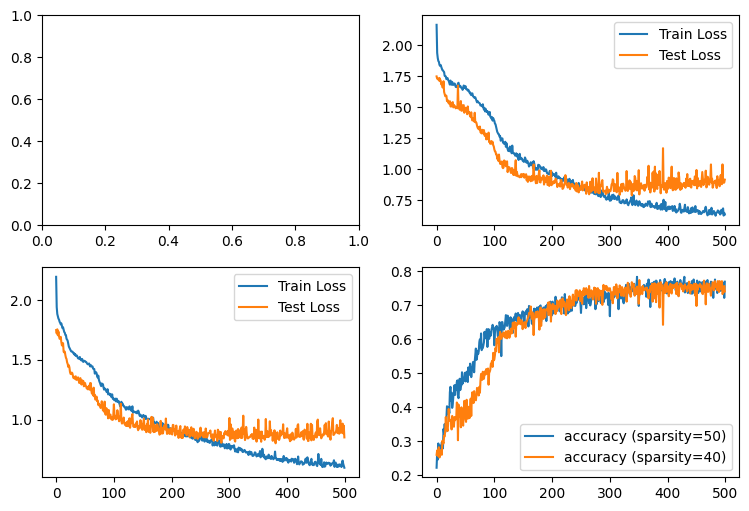

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# Plot train and test loss on first subplot
#sns.lineplot(x=range(1000), y=train_loss_wp[:1000], label="Train Loss", ax=axs[0,0])
#sns.lineplot(x=range(1000), y=test_loss_wp[:1000], label="Test Loss", ax=axs[0,0])

sns.lineplot(x=range(500), y=train_loss_rp40[:500], label="Train Loss", ax=axs[0,1])
sns.lineplot(x=range(500), y=test_loss_rp40[:500], label="Test Loss", ax=axs[0,1])

sns.lineplot(x=range(500), y=train_loss_rp50[:500], label="Train Loss", ax=axs[1,0])
sns.lineplot(x=range(500), y=test_loss_rp50[:500], label="Test Loss", ax=axs[1,0])

sns.lineplot(x=range(500), y=acc_rp50[:500], label="accuracy (sparsity=50)", ax=axs[1,1])
sns.lineplot(x=range(500), y=acc_rp40[:500], label="accuracy (sparsity=40)", ax=axs[1,1])

In [22]:
import matplotlib.pyplot as plt

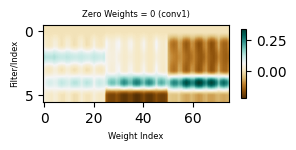

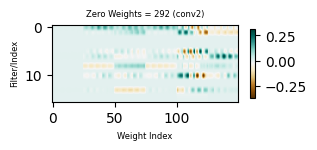

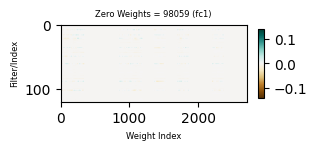

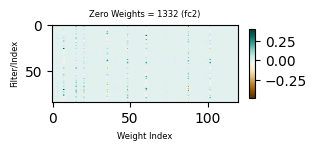

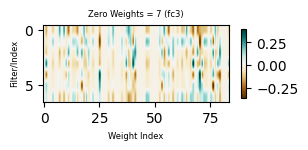

In [42]:
for name, module in model_rp50.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        weights = module.weight.data.cpu().numpy()
        num_zeros = np.count_nonzero(np.abs(weights) < 1e-9)
        #print(f"Number of zeros in {name} weights: {num_zeros}")

        # Reshape weight tensor to shape of filter/kernel
        filter_size = weights.shape[0]
        weights = weights.reshape(filter_size, -1)

        # Plot heatmap of weights after pruning
        fig, ax = plt.subplots(figsize=(3, 1))
        im = ax.imshow(weights, cmap='BrBG', aspect='auto')
        ax.set_title(f"Zero Weights = {num_zeros} ({name})", fontsize = 6)
        ax.set_xlabel("Weight Index", fontsize = 6)
        ax.set_ylabel("Filter/Index", fontsize = 6)
        fig.colorbar(im, shrink=0.9, aspect=12)
        plt.show()

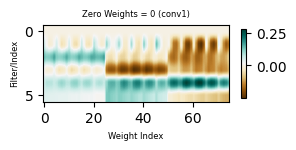

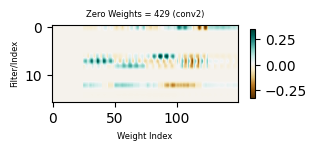

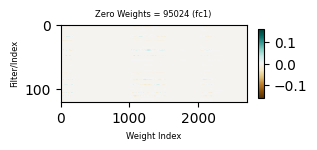

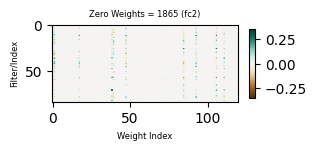

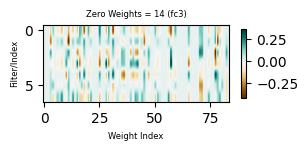

In [58]:
for name, module in model_rp40.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        weights = module.weight.data.cpu().numpy()
        num_zeros = np.count_nonzero(np.abs(weights) < 1e-9)
        #print(f"Number of zeros in {name} weights: {num_zeros}")

        # Reshape weight tensor to shape of filter/kernel
        filter_size = weights.shape[0]
        weights = weights.reshape(filter_size, -1)

        # Plot heatmap of weights after pruning
        fig, ax = plt.subplots(figsize=(3, 1))
        im = ax.imshow(weights, cmap='BrBG', aspect='auto')
        ax.set_title(f"Zero Weights = {num_zeros} ({name})", fontsize = 6)
        ax.set_xlabel("Weight Index", fontsize = 6)
        ax.set_ylabel("Filter/Index", fontsize = 6)
        fig.colorbar(im, shrink=0.9, aspect=12)
        plt.show()

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes=7):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class LeNetStudent(nn.Module):
    def __init__(self, num_classes=7):
        super(LeNetStudent, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(12 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
# Define the temperature and alpha hyperparameters
temperature = 5
alpha = 0.5

# Define the loss functions
criterion_teacher = nn.CrossEntropyLoss()
criterion_student = nn.KLDivLoss(reduction='batchmean')

# Define the optimizer
optimizer_student = optim.Adam(model_student.parameters(), lr=0.001)

# Train the teacher model
model_teacher = LeNet(num_classes=7)
criterion_teacher = nn.CrossEntropyLoss()
optimizer_teacher = optim.Adam(model_teacher.parameters(), lr=0.001)

model_teacher.train()

for epoch in range(10):
    for images, labels in train_loader:
        optimizer_teacher.zero_grad()
        output = model_teacher(images)
        loss = criterion_teacher(output, labels)
        loss.backward()
        optimizer_teacher.step()
    print(f'Epoch {epoch+1} loss: {loss.item()}')

# Train the student model
model_student = LeNetStudent(num_classes=7)
criterion_student = nn.KLDivLoss(reduction='batchmean')
optimizer_student = optim.Adam(model_student.parameters(), lr=0.001)

model_teacher.eval()
model_student.train()

for epoch in range(10):
    for images, labels in train_loader:
        optimizer_student.zero_grad()
        output_teacher = model_teacher(images)
        output_student = model_student(images)
        loss_teacher = criterion_teacher(output_teacher, labels)
        loss_student = criterion_student(torch.log_softmax(output_student/temperature, dim=1), torch.softmax(output_teacher/temperature, dim=1))
        loss = alpha * loss_teacher + (1 - alpha) * loss_student * temperature ** 2
        loss.backward()
        optimizer_student.step()
    print(f'Epoch {epoch+1} loss: {loss.item()}')

# Evaluate the student model on the test set
model_student.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        output = model_student(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')
correct this code and explain the code